# LendingClub Charge Offs prediction with EDA

**By Bartlomiej Lesniowski**

***04.12.2024***

<h2> 1. Introduction

LendingClub is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform. Description found on Wikipedia:

    LendingClub enabled borrowers to create unsecured personal loans between $1,000 and $40,000. The standard loan period was three years. Investors were able to search and browse the loan listings on LendingClub website and select loans that they wanted to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors made money from the interest on these loans. LendingClub made money by charging borrowers an origination fee and investors a service fee. 



### Project goal

The goal of this project is to build a machine learning model to predict the probability that a loan will charge off. We will use the data available to investors via the LendingClub loan listing, including information about the borrower. Such a predictive model could help LendingClub investors make better-informed investment decisions. We will only consider loans that LendingClub accepted under its credit underwriting policy.

### Import necessary libraries and the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
from scipy.stats import skew

%matplotlib inline

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

sns.set()

%matplotlib inline

<h2> 2. Dataset preparation

As my Dataset contains 151 columns (1,55GB), I decided to select and use in this project columns know to investors before acceptance of the loan

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
loans = pd.read_csv('accepted_2007_to_2018Q4.csv', usecols = ['id', 'member_id', 'desc', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies'],low_memory = False)

In [3]:
loans.shape

(2260701, 32)

In [4]:
loans.head()

,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,68407277,NaN,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,...,679.00,7.00,0.00,2765.00,29.70,13.00,w,Individual,1.00,0.00
1,68355089,NaN,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,...,719.00,22.00,0.00,21470.00,19.20,38.00,w,Individual,4.00,0.00
2,68341763,NaN,20000.00,60 months,10.78,432.66,B,B4,truck driver,10+ years,...,699.00,6.00,0.00,7869.00,56.20,18.00,w,Joint App,5.00,0.00
3,66310712,NaN,35000.00,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,...,789.00,13.00,0.00,7802.00,11.60,17.00,w,Individual,1.00,0.00
4,68476807,NaN,10400.00,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,...,699.00,12.00,0.00,21929.00,64.50,35.00,w,Individual,6.00,0.00


In [5]:
description = pd.read_excel('LCDataDictionary_2018.xlsx').dropna()
description.style.set_properties(subset=['Description'], **{'width' :'850px'})

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


<h2> 3. Data Processing

<h3> 3.1. Target feature preparation

Our goal is to predict if loan will be charged off. Let's check loan_status variable


In [6]:
loans['loan_status'].value_counts(dropna = False)

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: count, dtype: int64

We are interested only with the loans completed - "Fully Paid" and "Charged Off". There are 2 additional statuses: "Does not meet the credit policy. Status:Fully Paid" and "Does not meet the credit policy. Status:Charged Off". As Target statuses are unbalanced I will not include these statuses in our project. I will drop all statuses exept Fully Paid and Charged Off.

In [7]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [8]:
loans.shape

(1345310, 32)

Number of rows dropped to 1345310. Let's check how balanced is the data.

In [9]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

loan_status
Fully Paid    0.80
Charged Off   0.20
Name: proportion, dtype: float64

The data is very unbalanced (80% of the loans have been Fully Paid and 20% Carged Off). It may cause prediction problems. I will try balance the data.

<h3> 3.2. Clearing the dataset

I will check if we have columns with null values

In [10]:
missing_data = loans.isnull().mean().sort_values(ascending=False)
missing_data.head(20)

member_id              1.00
desc                   0.91
emp_title              0.06
emp_length             0.06
mort_acc               0.04
title                  0.01
revol_util             0.00
pub_rec_bankruptcies   0.00
dti                    0.00
zip_code               0.00
sub_grade              0.00
fico_range_low         0.00
loan_amnt              0.00
application_type       0.00
initial_list_status    0.00
total_acc              0.00
term                   0.00
revol_bal              0.00
pub_rec                0.00
open_acc               0.00
dtype: float64

It looks that there is a lot of empty or almost empty columns. I'll visualize it.

Text(0, 0.5, 'Feature count')

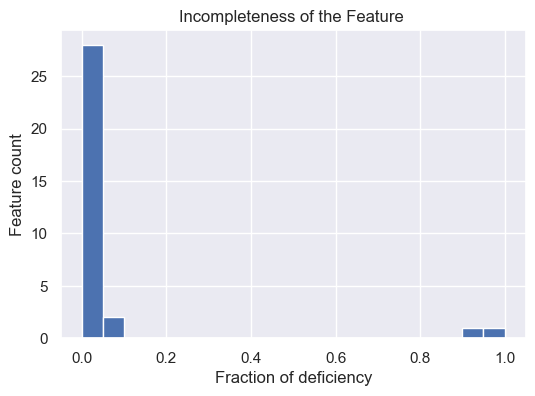

In [11]:
plt.figure(figsize=(6,4), dpi = 100)
missing_data.plot.hist(bins=20)
plt.title('Incompleteness of the Feature ')
plt.xlabel('Fraction of deficiency')
plt.ylabel('Feature count')

From this histogram we see couple of columns with almost 100% missing data. I decided to throw away all features with 30% null values.

In [12]:
drop_data = sorted(list(missing_data[missing_data > 0.30].index))
len(drop_data)

2

2 columns will be dropped

In [13]:
print(drop_data)

['desc', 'member_id']


In [14]:
loans.drop(labels=drop_data, axis=1, inplace=True)
loans.shape

(1345310, 30)

In [15]:
missing_data = loans.isnull().mean().sort_values(ascending=False)
missing_data.head(20)

emp_title              0.06
emp_length             0.06
mort_acc               0.04
title                  0.01
revol_util             0.00
pub_rec_bankruptcies   0.00
dti                    0.00
zip_code               0.00
sub_grade              0.00
home_ownership         0.00
term                   0.00
application_type       0.00
initial_list_status    0.00
total_acc              0.00
int_rate               0.00
revol_bal              0.00
pub_rec                0.00
open_acc               0.00
fico_range_high        0.00
fico_range_low         0.00
dtype: float64

There are 4 features with more than 1% missing values. I'll check them and then decide what to do with them.

In [16]:
missing_data.head(4)

emp_title    0.06
emp_length   0.06
mort_acc     0.04
title        0.01
dtype: float64

In [17]:
loans['emp_title'].describe()

count     1259525
unique     378353
top       Teacher
freq        21268
Name: emp_title, dtype: object

As there are 378353 unique titles, I decided to drop column "emp_title"

In [18]:
loans.drop(['emp_title'], axis = 1,inplace = True)

The next column is emp_length

In [19]:
loans['emp_length'].describe()

count       1266799
unique           11
top       10+ years
freq         442199
Name: emp_length, dtype: object

In [20]:
loans['emp_length'].value_counts(dropna = False)

emp_length
10+ years    442199
2 years      121743
< 1 year     108061
3 years      107597
1 year        88494
5 years       84154
4 years       80556
NaN           78511
6 years       62733
8 years       60701
7 years       59624
9 years       50937
Name: count, dtype: int64

There are 78511 null values. I will drop all rows with NaN in this column.

In [21]:
loans.dropna(subset=['emp_length'], axis = 0, inplace = True)

In [22]:
loans['emp_length'].value_counts(dropna = False)

emp_length
10+ years    442199
2 years      121743
< 1 year     108061
3 years      107597
1 year        88494
5 years       84154
4 years       80556
6 years       62733
8 years       60701
7 years       59624
9 years       50937
Name: count, dtype: int64

In [23]:
loans.shape

(1266799, 29)

Let's check mort_acc

In [24]:
loans['mort_acc'].value_counts(dropna = False)

mort_acc
0.00     493857
1.00     213658
2.00     177907
3.00     130463
4.00      88592
5.00      53763
NaN       45941
6.00      30339
7.00      15647
8.00       7825
9.00       4011
10.00      2052
11.00      1119
12.00       600
13.00       325
14.00       232
15.00       127
16.00        91
17.00        59
18.00        46
19.00        27
20.00        24
21.00        14
22.00        14
24.00        12
23.00        10
25.00         8
27.00         8
26.00         6
29.00         4
34.00         3
28.00         3
30.00         2
32.00         2
37.00         2
31.00         2
47.00         1
51.00         1
36.00         1
35.00         1
Name: count, dtype: int64

There are 45941 nulls. I will drop NaN values.

In [25]:
loans.dropna(subset=['mort_acc'], axis = 0, inplace = True)

In [26]:
loans.shape

(1220858, 29)

The last column with more than 1% of null values is title

In [27]:
loans['title'].value_counts(dropna = False)

title
Debt consolidation                    622761
Credit card refinancing               234340
Home improvement                       69423
Other                                  61683
Major purchase                         22610
                                       ...  
Becoming free                              1
consolidate and home improvement           1
Pay off Juniper                            1
furnishings                                1
Credit Card  Debt Elimination Loan         1
Name: count, Length: 42268, dtype: int64

In [28]:
loans['title'].describe()

count                1206431
unique                 42267
top       Debt consolidation
freq                  622761
Name: title, dtype: object

There are 42267 unique titles. Similarly to emp_title it is impossible to use it in our prediction, therefore I will drop this feature.

In [29]:
loans.drop(['title'], axis = 1,inplace = True)

Due to of low fraction of rows with 1 or more null values I will drop these rows.

In [30]:
loans.dropna(inplace = True)
loans.shape

(1220091, 28)

My next step is to drop all the columns which contains only unique values

In [31]:
for c in loans.columns:
    print ("---- %s ---" % c)
    print (loans[c].describe(include=['category']))

---- id ---
count      1220091
unique     1220091
top       68407277
freq             1
Name: id, dtype: object
---- loan_amnt ---
count   1220091.00
mean      14712.03
std        8764.86
min        1000.00
25%        8000.00
50%       12500.00
75%       20000.00
max       40000.00
Name: loan_amnt, dtype: float64
---- term ---
count        1220091
unique             2
top        36 months
freq          919861
Name: term, dtype: object
---- int_rate ---
count   1220091.00
mean         13.27
std           4.80
min           5.31
25%           9.75
50%          12.74
75%          16.02
max          30.99
Name: int_rate, dtype: float64
---- installment ---
count   1220091.00
mean        446.77
std         263.16
min           4.93
25%         255.30
50%         382.63
75%         593.06
max        1719.83
Name: installment, dtype: float64
---- grade ---
count     1220091
unique          7
top             B
freq       355792
Name: grade, dtype: object
---- sub_grade ---
count     1220091
un

There are 2 columns to be dropped. Id and zip_code.

In [32]:
loans.drop(['id','zip_code'], axis = 1, inplace = True)

In [33]:
for c in loans.columns:
    print ("---- %s ---" % c)
    print (loans[c].describe(include=['category']))

---- loan_amnt ---
count   1220091.00
mean      14712.03
std        8764.86
min        1000.00
25%        8000.00
50%       12500.00
75%       20000.00
max       40000.00
Name: loan_amnt, dtype: float64
---- term ---
count        1220091
unique             2
top        36 months
freq          919861
Name: term, dtype: object
---- int_rate ---
count   1220091.00
mean         13.27
std           4.80
min           5.31
25%           9.75
50%          12.74
75%          16.02
max          30.99
Name: int_rate, dtype: float64
---- installment ---
count   1220091.00
mean        446.77
std         263.16
min           4.93
25%         255.30
50%         382.63
75%         593.06
max        1719.83
Name: installment, dtype: float64
---- grade ---
count     1220091
unique          7
top             B
freq       355792
Name: grade, dtype: object
---- sub_grade ---
count     1220091
unique         35
top            C1
freq        77798
Name: sub_grade, dtype: object
---- emp_length ---
count    

In [34]:
loans.shape

(1220091, 26)

26 columns left. There is column with months and years - earliest_cr_line. We do not need so detailed dates. I will convert it to year only. 

In [35]:
loans['earliest_cr_line'] = pd.DatetimeIndex(loans['earliest_cr_line']).year.astype(int)
#loans['earliest_cr_line'] = loans['earliest_cr_line'].astype(str)

In [36]:
for c in loans.columns:
    print ("---- %s ---" % c)
    print (loans[c].describe(include=['category']))

---- loan_amnt ---
count   1220091.00
mean      14712.03
std        8764.86
min        1000.00
25%        8000.00
50%       12500.00
75%       20000.00
max       40000.00
Name: loan_amnt, dtype: float64
---- term ---
count        1220091
unique             2
top        36 months
freq          919861
Name: term, dtype: object
---- int_rate ---
count   1220091.00
mean         13.27
std           4.80
min           5.31
25%           9.75
50%          12.74
75%          16.02
max          30.99
Name: int_rate, dtype: float64
---- installment ---
count   1220091.00
mean        446.77
std         263.16
min           4.93
25%         255.30
50%         382.63
75%         593.06
max        1719.83
Name: installment, dtype: float64
---- grade ---
count     1220091
unique          7
top             B
freq       355792
Name: grade, dtype: object
---- sub_grade ---
count     1220091
unique         35
top            C1
freq        77798
Name: sub_grade, dtype: object
---- emp_length ---
count    

In [37]:
for c in loans.columns:
    print ("---- %s ---" % c)
    print (loans[c].value_counts().head(15))

---- loan_amnt ---
loan_amnt
10000.00    89719
12000.00    66844
20000.00    65363
15000.00    64282
35000.00    48958
8000.00     42843
5000.00     42138
6000.00     39409
16000.00    34206
25000.00    31240
24000.00    31000
18000.00    28643
30000.00    27473
7000.00     20950
28000.00    18835
Name: count, dtype: int64
---- term ---
term
 36 months    919861
 60 months    300230
Name: count, dtype: int64
---- int_rate ---
int_rate
10.99    34698
11.99    30457
13.99    27233
5.32     27049
9.17     24617
7.89     23765
12.99    23712
15.61    21420
16.99    21012
9.99     17792
11.49    16442
14.99    15580
12.29    15456
8.18     15348
12.69    15010
Name: count, dtype: int64
---- installment ---
installment
327.34    2850
301.15    2483
332.10    2460
318.79    2157
312.86    1935
491.01    1931
392.81    1896
361.38    1885
602.30    1826
451.73    1817
336.90    1768
654.68    1690
382.55    1600
261.88    1567
498.15    1561
Name: count, dtype: int64
---- grade ---
grade
B    

In [38]:
loans.shape

(1220091, 26)

In [39]:
missing_data = loans.isnull().mean().sort_values(ascending=False)
missing_data.head()

loan_amnt             0.00
term                  0.00
mort_acc              0.00
application_type      0.00
initial_list_status   0.00
dtype: float64

After dataset clearance 26 columns left with 1220091 rows without nulls.

<h2> 4. Exploratory Data Analysis

<h3> 4.1. Defining funcions

Visualize a variable without faceting on the loan status.

    col_name is the variable name in the dataframe
    full_name is the full variable name
    continuous is True if the variable is continuous, False otherwise

In [40]:
def plot_var(col_name, full_name, continuous):

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
  
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax1)
        ax1.set_ylabel('')
        ax1.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
        ax2.set_xlabel(full_name)    

    if continuous:
        sns.histplot(loans.loc[loans[col_name].notnull(), col_name])
    else:
        sns.countplot(x = loans[col_name], order=sorted(loans[col_name].unique()), 
                      color='#5975A4', saturation=1, ax=ax1)

<h3> 4.2. Data Analysis

I'll inspect all features and if it's necessary modify or drop them.<br>
For each column I'll provide name and definition from Lending Club Data Dictionary

In [41]:
loans.shape

(1220091, 26)

In [42]:
print(list(loans.columns))

['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


<h4> 4.2.1. loan_amnt

The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [43]:
col = 'loan_amnt'

In [44]:
loans[col].describe()

count   1220091.00
mean      14712.03
std        8764.86
min        1000.00
25%        8000.00
50%       12500.00
75%       20000.00
max       40000.00
Name: loan_amnt, dtype: float64

The range of the loan amount is from 1000$ to 40000$, median is 12500$. Let's check if there are some differencies grouped by our target.

In [45]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240673.00,15959.77,8829.78,1000.00,9600.00,15000.00,21000.00,40000.00
Fully Paid,979418.00,14405.43,8721.56,1000.00,8000.00,12000.00,20000.00,40000.00


Mean of Charged Off loans is higher than Fully Paid

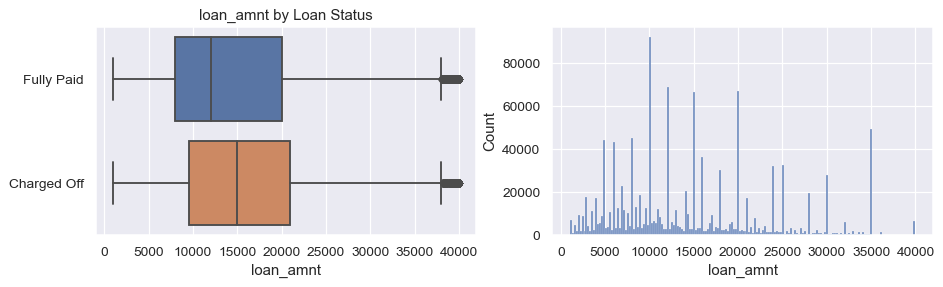

In [46]:
plot_var(col, col, continuous=1)

In [47]:
skew(loans[col])

0.7535581696114383

There is high skewnes in this feature. I will log transform this feature.

In [48]:
loans['log_loan_amnt'] = loans[col].apply(lambda x: np.log10(x+1))

In [49]:
skew(loans['log_loan_amnt'])

-0.673117577126921

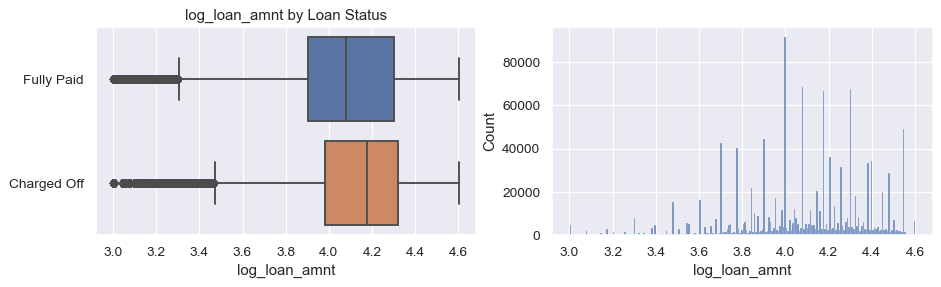

In [50]:
plot_var('log_loan_amnt', 'log_loan_amnt', continuous=1)

There is no significat change after log transform. I will leave original one and drop all values higher or equal to 35000

In [51]:
loans = loans.drop(loans[(loans[col]>=35000)].index).reset_index(drop=True)

In [52]:
skew(loans[col])

0.5687093481320674

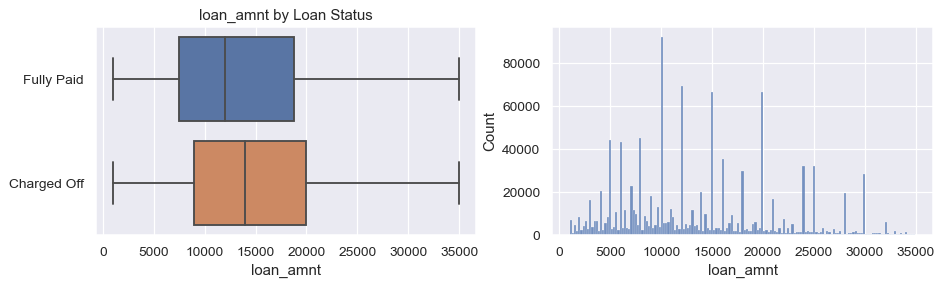

In [53]:
plot_var(col, col, continuous=1)

Skewness is still high, but there are no outliers.

In [54]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,226926.00,14773.11,7608.90,1000.00,9000.00,14000.00,20000.00,34975.00
Fully Paid,935219.00,13400.64,7560.52,1000.00,7500.00,12000.00,18750.00,34975.00


The table above shows that there is higher probability to be Charged Off, when loan amount is higher.

In [55]:
loans.drop(['log_loan_amnt'], axis = 1, inplace = True)

<h4> 4.2.2. term

The number of payments on the loan. Values are in months and can be either 36 or 60.

In [56]:
col = 'term'

In [57]:
loans[col].value_counts()

term
 36 months    888236
 60 months    273909
Name: count, dtype: int64

In [58]:
loans[col].value_counts(normalize = True)

term
 36 months   0.76
 60 months   0.24
Name: proportion, dtype: float64

There is 3 times more loans for 36 months than 60 months.

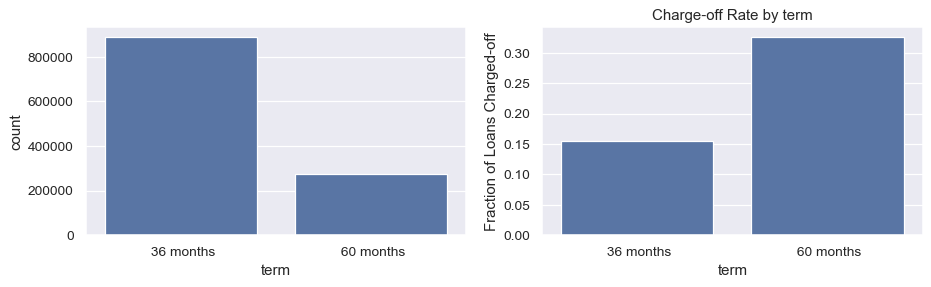

In [59]:
plot_var(col, col, continuous=False)

In [60]:
loans.groupby(col)['loan_status'].value_counts(normalize=True)

term        loan_status
 36 months  Fully Paid    0.85
            Charged Off   0.15
 60 months  Fully Paid    0.67
            Charged Off   0.33
Name: proportion, dtype: float64

Loans with longer payment period has twice more chance to be Charged Off - 33%. 

<h4> 4.2.3. int_rate

Interest Rate on the loan.

In [61]:
col = 'int_rate'

In [62]:
loans[col].describe()

count   1162145.00
mean         13.18
std           4.76
min           5.31
25%           9.67
50%          12.73
75%          15.99
max          30.99
Name: int_rate, dtype: float64

Interest Rate varies between 5.31% and 30.99%

In [63]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,226926.00,15.70,4.89,5.31,12.29,15.04,18.55,30.99
Fully Paid,935219.00,12.57,4.52,5.31,9.17,12.12,15.10,30.99


Borrowers with higher Interest rate are more tend to Charge Off loans

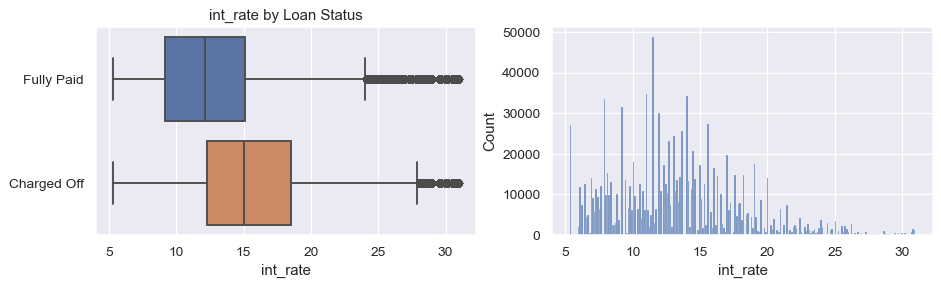

In [64]:
plot_var(col,col, continuous=True)

In [65]:
skew(loans[col])

0.7206152233016321

There is high skewness. I decided to log transform this feature

In [66]:
loans['log_int_rate'] = loans[col].apply(lambda x: np.log10(x+2))

In [67]:
skew(loans['log_int_rate'])

-0.06313929319320388

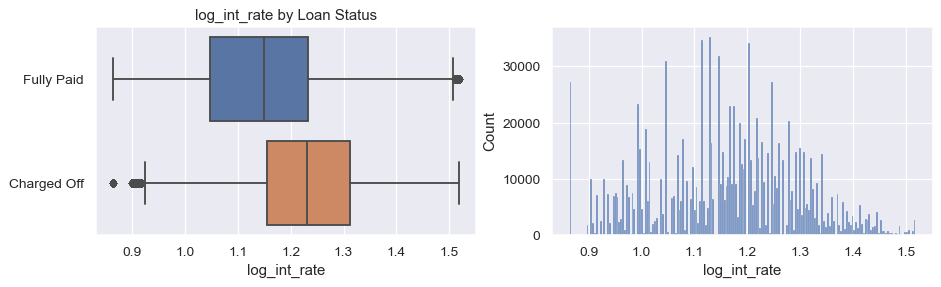

In [68]:
plot_var('log_int_rate','log_int_rate', continuous=True)

In [69]:
(loans['log_int_rate'] < 0.9).sum()

28932

As there are some outliers below 0.9 I decided to drop all values below.

In [70]:
loans = loans.drop(loans[(loans['log_int_rate'] < 0.9)].index).reset_index(drop=True)

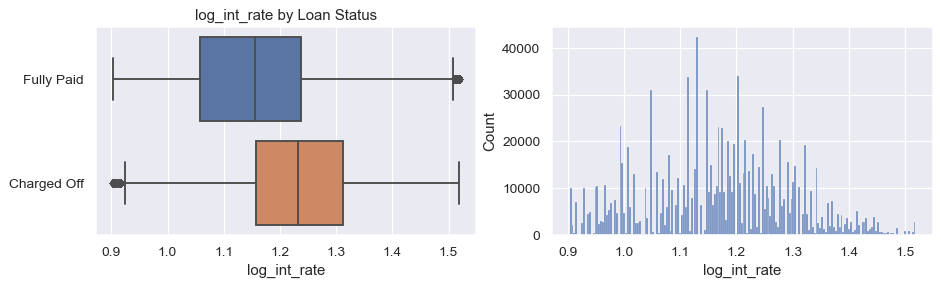

In [71]:
plot_var('log_int_rate','log_int_rate', continuous=True)

In [72]:
skew(loans['log_int_rate'])

0.05317253350364761

In [73]:
(loans['log_int_rate'] > 1.5).sum()

4800

I will drop all values higher than 1.5 as well

In [74]:
loans = loans.drop(loans[(loans['log_int_rate'] > 1.5)].index).reset_index(drop=True)

In [75]:
skew(loans['log_int_rate'])

0.005381470245375695

In [76]:
loans.drop(['int_rate'], axis = 1, inplace = True)

<h4> 4.2.4. installment

The monthly payment owed by the borrower if the loan originates.

In [77]:
col = 'installment'

In [78]:
loans[col].describe()

count   1128413.00
mean        414.97
std         226.00
min           4.93
25%         249.30
50%         369.20
75%         550.14
max        1452.46
Name: installment, dtype: float64

There is huge gap between minimum and maximum installment. The monthly payment varies between 4.93 and 1498.08.

In [79]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,223699.00,439.44,223.31,21.62,276.60,395.55,571.74,1452.46
Fully Paid,904714.00,408.92,226.25,4.93,241.53,361.93,543.63,1431.11


Installment mean, minimum and maximum are higher for Charged Off loans

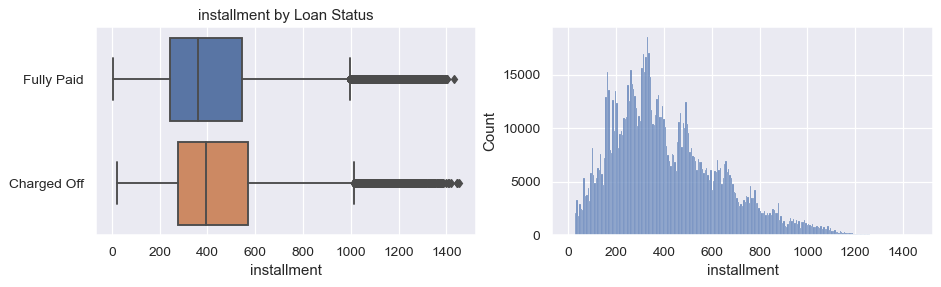

In [80]:
plot_var(col, col, continuous=True)

In [81]:
skew(loans[col])

0.7861475395050641

This feature has high skewness (78%) and a lot of outliers. I will try to log tansform this feature

In [82]:
loans['log_Installment'] = loans[col].apply(lambda x: np.log10(x))

In [83]:
skew(loans['log_Installment'])

-0.746766431763586

Log tranform was not effective way to deal with skewness. 
Outliers starts around 1000 for Fully Paid and Charged Off loan status. I'll drop installment higher than 1000

In [84]:
loans = loans.drop(loans[(loans[col]>=1000)].index).reset_index(drop=True)

In [85]:
skew(loans[col])

0.5923382359704736

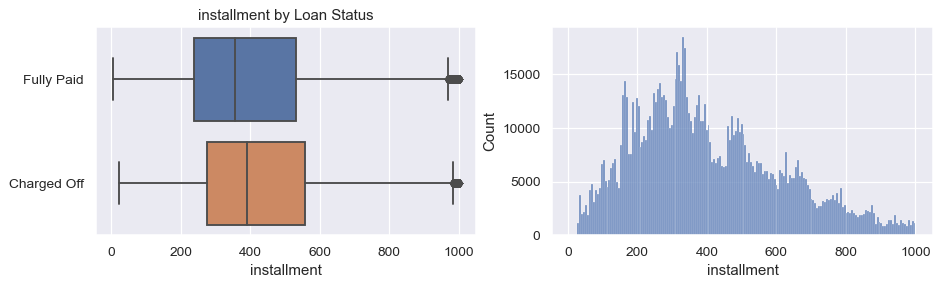

In [86]:
plot_var(col, col, continuous=True)

Outliers are still visible. I will drop data equal or higher than 950.

In [87]:
loans = loans.drop(loans[(loans[col]>=950)].index).reset_index(drop=True)

In [88]:
skew(loans[col])

0.5296224531447365

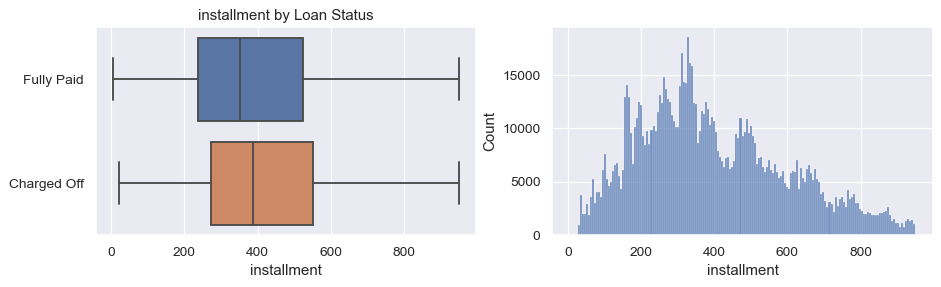

In [89]:
plot_var(col, col, continuous=True)

Skewness is still high, but outliers are not visible. I will not perform additional clearance.

In [90]:
loans[col].describe()

count   1099184.00
mean        398.23
std         203.62
min           4.93
25%         246.04
50%         361.67
75%         531.36
max         949.98
Name: installment, dtype: float64

In [91]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,217014.00,420.39,197.57,21.62,273.35,387.05,552.12,949.97
Fully Paid,882170.00,392.78,204.72,4.93,237.65,353.01,524.56,949.98


Charged-off loans tend to have higher installments.

<h4> 4.2.5. grade and sub_grade 

In [92]:
col = 'grade'

In [93]:
loans[col].describe()

count     1099184
unique          7
top             B
freq       336477
Name: grade, dtype: object

In [94]:
loans.groupby('loan_status')[col].describe()

,count,unique,top,freq
loan_status,,,,
Charged Off,217014,7,C,71470
Fully Paid,882170,7,B,292766


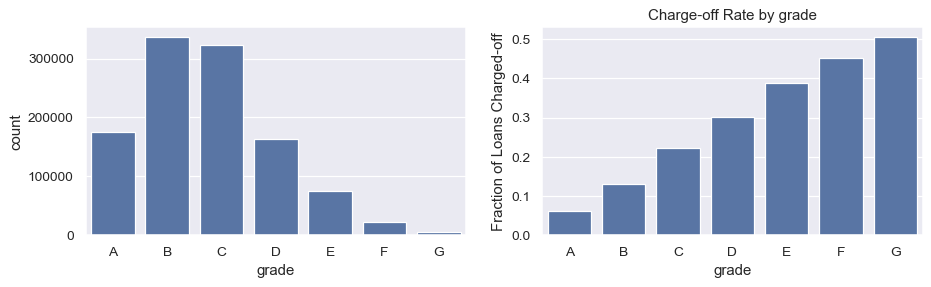

In [95]:
plot_var(col, col, continuous=False)

Loans with worse grades have higher probability to be Charged Off

In [96]:
col = 'sub_grade'

In [97]:
loans[col].describe()

count     1099184
unique         35
top            C1
freq        72416
Name: sub_grade, dtype: object

In [98]:
loans.groupby('loan_status')[col].describe()

,count,unique,top,freq
loan_status,,,,
Charged Off,217014,35,C4,15594
Fully Paid,882170,35,B4,61277


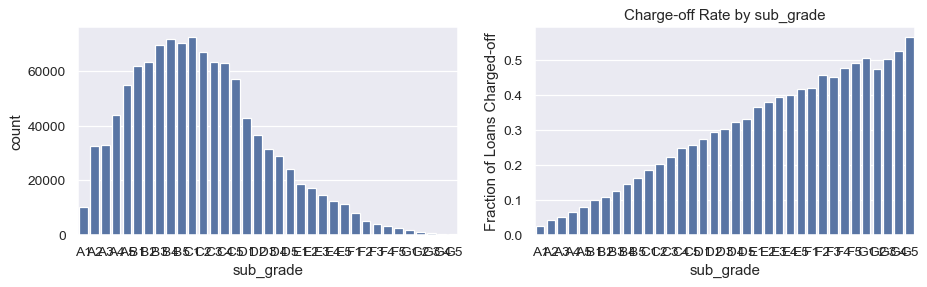

In [99]:
plot_var(col, col, continuous=False)

People with worse Sub Grade are more tend to Charge Off loans. As it is expanded feature of grade, I decided to not include this feature in my training models.

In [100]:
loans = loans.drop(['sub_grade'], axis = 1)

<h4> 4.2.6. emp_length

In [101]:
col = 'emp_length'

In [102]:
loans[col].describe()

count       1099184
unique           11
top       10+ years
freq         381599
Name: emp_length, dtype: object

In [103]:
loans[col].value_counts(dropna=False)

emp_length
10+ years    381599
2 years      106236
3 years       93519
< 1 year      93203
1 year        77589
5 years       72903
4 years       69387
6 years       54629
8 years       53268
7 years       52295
9 years       44556
Name: count, dtype: int64

Values doesn't match with description, there are "< 1 year" and "10+ years". I'll replace them with "0 year" and "10 years".

In [104]:
loans[col].replace(to_replace='10+ years', value='10 years', inplace=True)
loans[col].replace(to_replace='< 1 year', value='0 year', inplace=True)

In [105]:
loans.groupby('loan_status')[col].describe()

,count,unique,top,freq
loan_status,,,,
Charged Off,217014,11,10 years,72229
Fully Paid,882170,11,10 years,309370


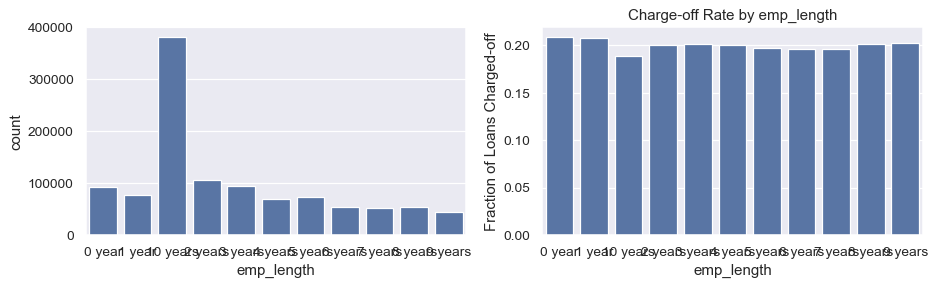

In [106]:
plot_var(col, col, continuous=False)

In [107]:
loans.groupby(col)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

emp_length
10 years   0.19
6 years    0.20
7 years    0.20
5 years    0.20
4 years    0.20
2 years    0.20
8 years    0.20
3 years    0.20
9 years    0.20
1 year     0.21
0 year     0.21
Name: proportion, dtype: float64

Length of employment does not affect on loan status. 

<h4> 4.2.7. home_ownership

In [108]:
col = 'home_ownership'

In [109]:
loans[col].describe()

count      1099184
unique           6
top       MORTGAGE
freq        531936
Name: home_ownership, dtype: object

In [110]:
loans[col].value_counts()

home_ownership
MORTGAGE    531936
RENT        453812
OWN         113134
ANY            224
NONE            39
OTHER           39
Name: count, dtype: int64

There are 3 types with small amount of home ownership: ANY, NONE, OTHER. To simplify analysis, I will sum it up to one type - OTHER

In [111]:
loans[col].replace(to_replace = 'ANY', value = 'OTHER', inplace = True)
loans[col].replace(to_replace = 'NONE', value = 'OTHER', inplace = True)

In [112]:
loans.groupby('loan_status')[col].describe()

,count,unique,top,freq
loan_status,,,,
Charged Off,217014,4,RENT,103799
Fully Paid,882170,4,MORTGAGE,441452


In [113]:
loans[col].value_counts()

home_ownership
MORTGAGE    531936
RENT        453812
OWN         113134
OTHER          302
Name: count, dtype: int64

In [114]:
loans.groupby(col)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

home_ownership
MORTGAGE   0.17
OWN        0.20
OTHER      0.20
RENT       0.23
Name: proportion, dtype: float64

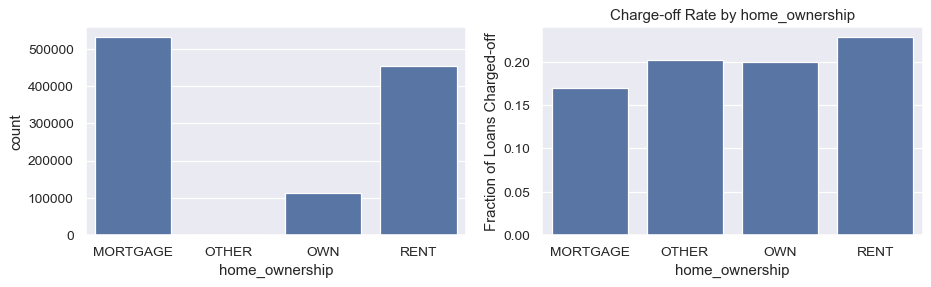

In [115]:
plot_var(col, col, continuous=False)

Borrowers who rent home has higher probability to Charge Off loan.

<h4> 4.2.8. annual_inc

In [116]:
col = 'annual_inc'

In [117]:
loans[col].describe()

count    1099184.00
mean       72997.49
std        64182.03
min           33.00
25%        45500.00
50%        63000.00
75%        87000.00
max     10999200.00
Name: annual_inc, dtype: float64

In [118]:
loans[col].value_counts()

annual_inc
60000.00     45772
50000.00     41210
65000.00     34451
70000.00     32388
40000.00     31939
             ...  
48746.22         1
168528.00        1
39841.00         1
86277.00         1
180792.00        1
Name: count, Length: 49830, dtype: int64

In [119]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,217014.00,67851.53,64167.79,100.00,44000.00,60000.00,80000.00,9500000.00
Fully Paid,882170.00,74263.40,64122.30,33.00,46800.00,65000.00,90000.00,10999200.00


People with lower annual income has higher probability to Charge Off loans

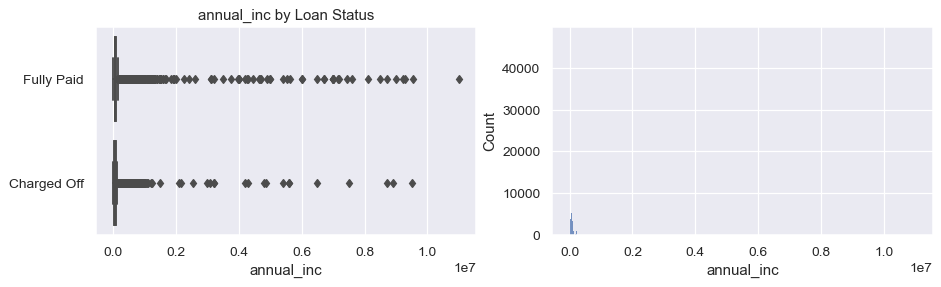

In [120]:
plot_var(col, col, continuous=True)

Because of the large range of incomes, I will log transform of the annual income variable.

In [121]:
loans['log_annual_inc'] = loans[col].apply(lambda x: np.log10(x+1))

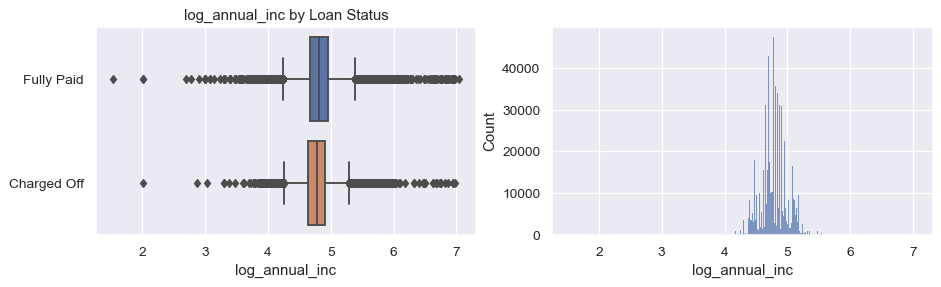

In [122]:
plot_var('log_annual_inc', 'log_annual_inc', continuous=True)

In [123]:
skew(loans['log_annual_inc'])

0.2337169112107083

There are some outliers below 2 and above 7. I will drop these values.

In [124]:
loans = loans.drop(loans[(loans['log_annual_inc'] >= 7)].index).reset_index(drop=True)
loans = loans.drop(loans[(loans['log_annual_inc'] <= 2)].index).reset_index(drop=True)

In [125]:
skew(loans['log_annual_inc'])

0.23596830938804872

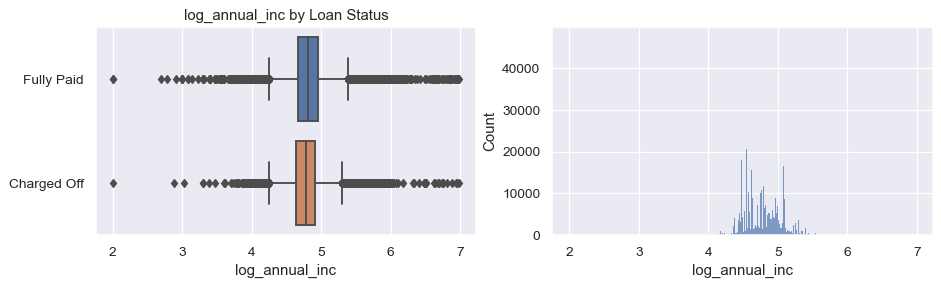

In [126]:
plot_var('log_annual_inc', 'log_annual_inc', continuous=True)

<h4> 4.2.9. verification_status

Indicates if income was verified by [Lending Club], not verified, or if the income source was verified.

In [127]:
col = 'verification_status'

In [128]:
loans[col].describe()

count             1099182
unique                  3
top       Source Verified
freq               448510
Name: verification_status, dtype: object

In [129]:
loans[col].value_counts()

verification_status
Source Verified    448510
Not Verified       349006
Verified           301666
Name: count, dtype: int64

In [130]:
loans.groupby('loan_status')[col].describe()

,count,unique,top,freq
loan_status,,,,
Charged Off,217014,3,Source Verified,94282
Fully Paid,882168,3,Source Verified,354228


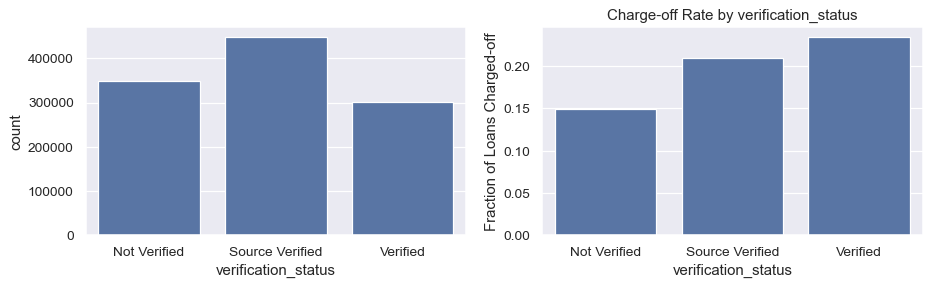

In [131]:
plot_var(col, col, continuous=False)

In [132]:
loans.groupby(col)['loan_status'].value_counts(normalize=True)

verification_status  loan_status
Not Verified         Fully Paid    0.85
                     Charged Off   0.15
Source Verified      Fully Paid    0.79
                     Charged Off   0.21
Verified             Fully Paid    0.77
                     Charged Off   0.23
Name: proportion, dtype: float64

There is higher chance that verified income will be Charged Off than Not Verified.

<h4> 4.2.10. purpose

In [133]:
col = 'purpose'
loans[col].describe()

count                1099182
unique                    14
top       debt_consolidation
freq                  645010
Name: purpose, dtype: object

In [134]:
loans[col].value_counts()

purpose
debt_consolidation    645010
credit_card           242161
home_improvement       67807
other                  63500
major_purchase         22543
medical                12837
car                    11394
small_business         10868
moving                  7945
vacation                7731
house                   5462
wedding                 1199
renewable_energy         724
educational                1
Name: count, dtype: int64

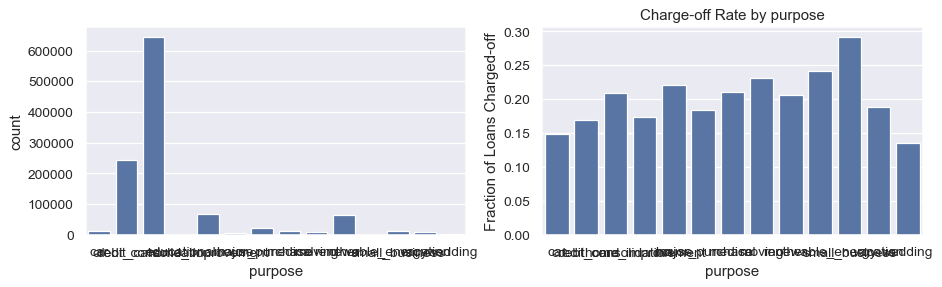

In [135]:
plot_var(col, col, continuous=False)

There are similar purposes like debt_consolidation and credit_card or home_improvement and house. There is renewable_energy as it is usually installed on houses. I will sum up them as debt_consolidation and house. Additionally there is 1 row with "educational" value, I will add is to "other".

In [136]:
loans[col].replace(to_replace = 'credit_card', value = 'debt_consolidation', inplace = True)
loans[col].replace(to_replace = 'home_improvement', value = 'house', inplace = True)
loans[col].replace(to_replace = 'educational', value = 'other', inplace = True)
loans[col].replace(to_replace = 'renewable_energy', value = 'house', inplace = True)

In [137]:
loans[col].value_counts()

purpose
debt_consolidation    887171
house                  73993
other                  63501
major_purchase         22543
medical                12837
car                    11394
small_business         10868
moving                  7945
vacation                7731
wedding                 1199
Name: count, dtype: int64

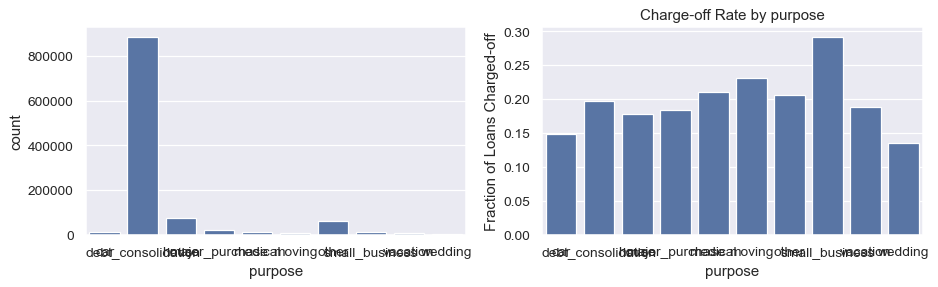

In [138]:
plot_var(col, col, continuous=False)

In [139]:
loans.groupby(col)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
wedding              0.14
car                  0.15
house                0.18
major_purchase       0.18
vacation             0.19
debt_consolidation   0.20
other                0.21
medical              0.21
moving               0.23
small_business       0.29
Name: proportion, dtype: float64

Only 14% of completed loans for weddings have been Charged Off, but 29% of completed small business loans have Charged Off

<h4> 4.2.11. addr_state

In [140]:
col = 'addr_state'
loans[col].describe()

count     1099182
unique         51
top            CA
freq       159108
Name: addr_state, dtype: object

In [141]:
loans[col].value_counts()

addr_state
CA    159108
TX     90072
NY     89439
FL     77366
IL     42207
NJ     39103
PA     37680
OH     36352
GA     35098
NC     30889
VA     30378
MI     28423
AZ     26489
MA     25343
MD     25280
CO     24534
WA     23841
MN     20301
IN     18637
MO     17362
TN     17212
NV     16450
CT     16040
WI     14809
AL     13661
OR     13498
SC     12847
LA     12826
KY     10654
OK     10116
KS      9373
UT      8406
AR      8202
NM      5924
HI      5549
MS      5464
NH      5321
RI      4929
WV      3937
MT      3224
NE      3075
DE      3049
DC      2685
AK      2577
WY      2458
SD      2352
VT      2255
ME      1635
ND      1382
ID      1368
IA         2
Name: count, dtype: int64

There are too many unique states. I will create new feature with regions that will include states.

In [142]:
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

In [143]:
loans['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    
loans['region'] = loans[col].apply(finding_regions)

In [144]:
col = 'region'

In [145]:
loans[col].describe()

count       1099182
unique            5
top       SouthEast
freq         264268
Name: region, dtype: object

In [146]:
loans[col].value_counts()

region
SouthEast    264268
West         261013
NorthEast    247025
MidWest      194275
SouthWest    132601
Name: count, dtype: int64

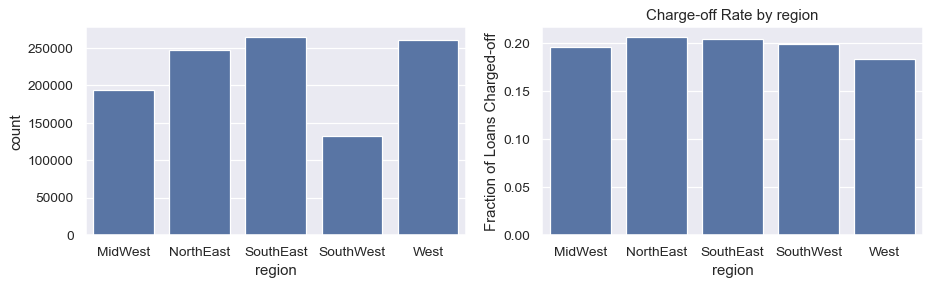

In [147]:
plot_var(col, col, continuous=False)

In [148]:
loans.groupby(col)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

region
West        0.18
MidWest     0.20
SouthWest   0.20
SouthEast   0.20
NorthEast   0.21
Name: proportion, dtype: float64

It looks that region does not affect on loan status

In [149]:
loans.drop(['addr_state'], axis = 1, inplace = True)

<h4> 4.2.12. dti

A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

In [150]:
col = 'dti'

In [151]:
loans[col].describe()

count   1099182.00
mean         18.40
std           9.42
min          -1.00
25%          12.00
50%          17.81
75%          24.28
max         999.00
Name: dti, dtype: float64

In [152]:
(loans[col]<0).sum()

2

There are 2 rows where Debt to income is negative. I performed investigation and this value is probably caused by incorrect calculation. I will drop them.

In [153]:
loans = loans.drop(loans[(loans[col] < 0)].index).reset_index(drop=True)

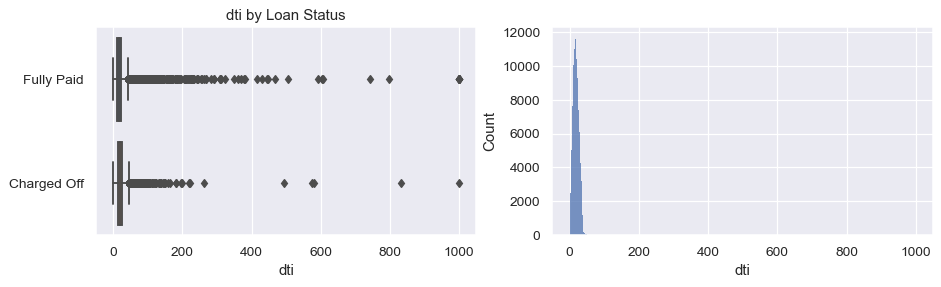

In [154]:
plot_var(col, col, continuous=True)

Text(0.5, 1.0, 'Debt-To-Income Ratio')

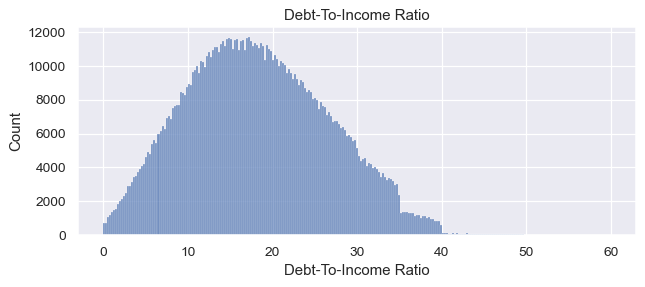

In [155]:
plt.figure(figsize=(8,3), dpi=90)
sns.histplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-To-Income Ratio')
plt.ylabel('Count')
plt.title('Debt-To-Income Ratio')

In [156]:
skew(loans[col])

12.658869775379042

Skewness is extremaly high. I will drop all values higher than 40

In [157]:
(loans[col]>40).sum()

4442

There are a lot of outliers and less than 4000 rows higher or eqal 40. I will drop them.

In [158]:
loans = loans.drop(loans[(loans[col] >=40)].index).reset_index(drop=True)

In [159]:
skew(loans[col])

0.2036579642448693

In [160]:
loans[col].describe()

count   1094736.00
mean         18.24
std           8.34
min           0.00
25%          11.97
50%          17.76
75%          24.19
max          39.99
Name: dti, dtype: float64

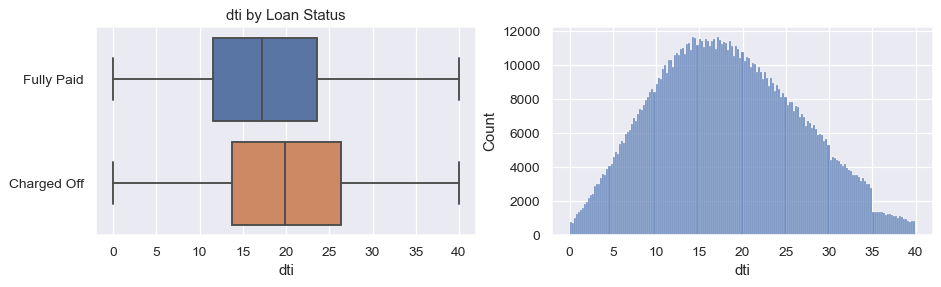

In [161]:
plot_var(col, col, continuous=True)

In [162]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,215715.00,20.01,8.48,0.00,13.72,19.86,26.30,39.99
Fully Paid,879021.00,17.80,8.24,0.00,11.61,17.27,23.61,39.99


Charged Off status has higher avarage debt-to-income ratio.


<h4> 4.2.13. earliest_cr_line

The month the borrower's earliest reported credit line was opened

In [163]:
col = 'earliest_cr_line' 

In [164]:
loans[col].describe()

count   1094736.00
mean       1999.27
std           7.27
min        1934.00
25%        1995.00
50%        2000.00
75%        2004.00
max        2015.00
Name: earliest_cr_line, dtype: float64

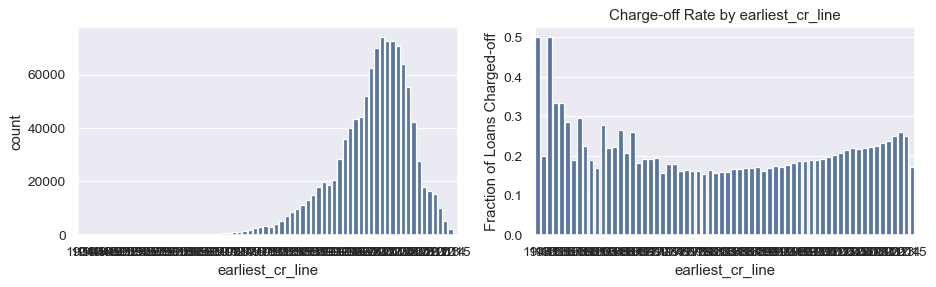

In [165]:
plot_var(col, col, continuous=False)

In [166]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,215715.00,1999.95,7.13,1944.00,1996.00,2001.00,2005.00,2015.00
Fully Paid,879021.00,1999.10,7.29,1934.00,1995.00,2000.00,2004.00,2015.00


Borrowers who are Charged Off tend to have shorter lines of credit.


<h4> 4.2.14. fico_range_low and fico_range_high

In [167]:
col = 'fico_range_low'

In [168]:
loans[['fico_range_low','fico_range_high']].describe()

,fico_range_low,fico_range_high
count,1094736.00,1094736.00
mean,693.74,697.74
std,29.95,29.95
min,660.00,664.00
25%,670.00,674.00
50%,685.00,689.00
75%,710.00,714.00
max,845.00,850.00


Values are almost the same. I will check Pearson correlation.

In [169]:
loans[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.00,1.00
fico_range_high,1.00,1.00


I need only one feature. I'll calculate avarage value of them and drop both of original features.

In [170]:
loans['FICO'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [171]:
col = 'FICO'

In [172]:
loans[col].describe()

count   1094736.00
mean        695.74
std          29.95
min         662.00
25%         672.00
50%         687.00
75%         712.00
max         847.50
Name: FICO, dtype: float64

In [173]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

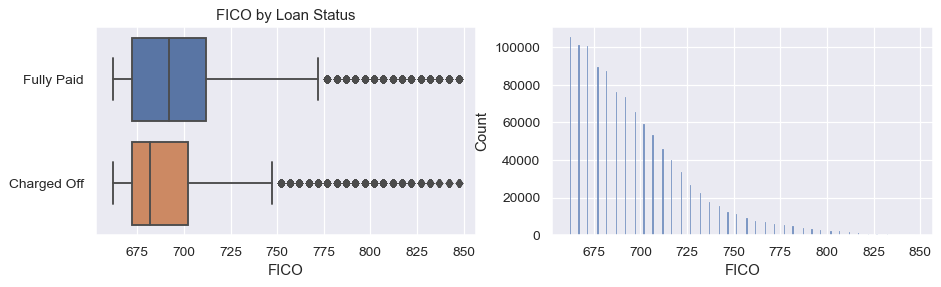

In [174]:
plot_var(col, col, continuous=True)

In [175]:
skew(loans[col])

1.336099334737049

In [176]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,215715.00,688.48,24.66,662.00,672.00,682.00,702.00,847.50
Fully Paid,879021.00,697.53,30.85,662.00,672.00,692.00,712.00,847.50


In [177]:
(loans[col] >= 775).sum()

28448

This feature is right-skewed. I will check 2 scenarios: 
- log transform this feature
- drop all values higher or equal 775

Log transform

In [178]:
loans['log_FICO'] = loans['FICO'].apply(lambda x: np.log10(x+1))

In [179]:
skew(loans['log_FICO'])

1.20524950816077

As Log transformation was not effective I decided to drop all values higher or equal 775

In [180]:
loans = loans.drop(loans[(loans[col] >= 775)].index).reset_index(drop=True)

In [181]:
loans[col].describe()

count   1066288.00
mean        693.13
std          25.51
min         662.00
25%         672.00
50%         687.00
75%         707.00
max         772.00
Name: FICO, dtype: float64

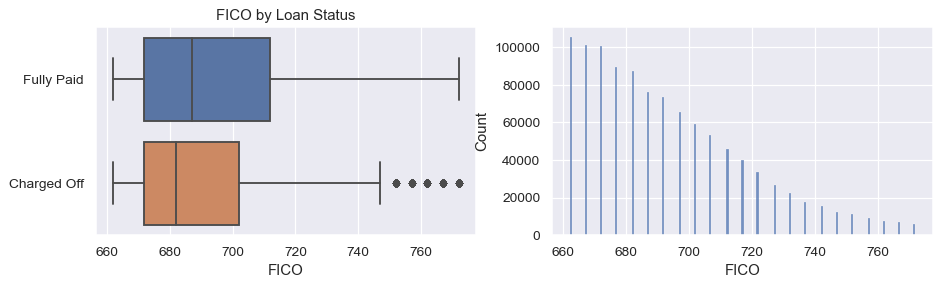

In [182]:
plot_var(col, col, continuous=True)

In [183]:
skew(loans[col])

0.8933374868388347

Skewness is still very high, but there are no outliers on Fully Paid status.

In [184]:
loans['log_FICO'] = loans['FICO'].apply(lambda x: np.log10(x+1))

In [185]:
skew(loans['log_FICO'])

0.817939502288194

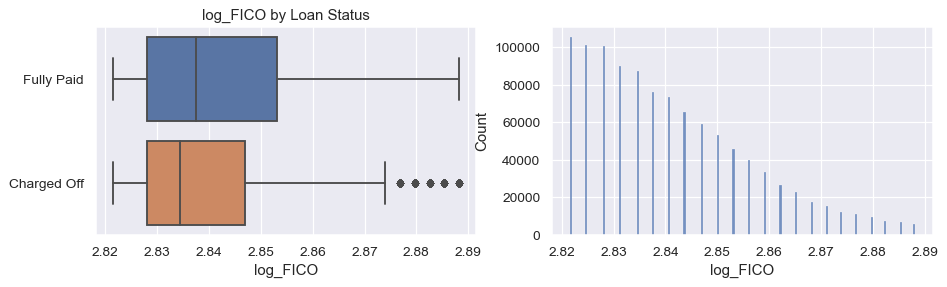

In [186]:
plot_var('log_FICO', 'log_FICO', continuous=True)

As it is hard to receive Normal Distribution for FICO score I decided to drop log_FICO feature.

In [187]:
loans.drop(['log_FICO'], axis = 1, inplace = True)

In [188]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,213636.00,687.47,22.51,662.00,672.00,682.00,702.00,772.00
Fully Paid,852652.00,694.54,26.02,662.00,672.00,687.00,712.00,772.00


Borrowers with lower FICO score more often Charged Off loan.

<h4> 4.2.15. open_acc

The number of open credit lines in the borrower's credit file

In [189]:
col = 'open_acc'

In [190]:
loans[col].describe()

count   1066288.00
mean         11.59
std           5.42
min           1.00
25%           8.00
50%          11.00
75%          14.00
max          86.00
Name: open_acc, dtype: float64

In [191]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,213636.00,11.96,5.59,1.00,8.00,11.00,15.00,76.00
Fully Paid,852652.00,11.50,5.37,1.00,8.00,11.00,14.00,86.00


In [192]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,213636.00,11.96,5.59,1.00,8.00,11.00,15.00,76.00
Fully Paid,852652.00,11.50,5.37,1.00,8.00,11.00,14.00,86.00


Borrowers with more credit lines are more tend to Charge Off loans

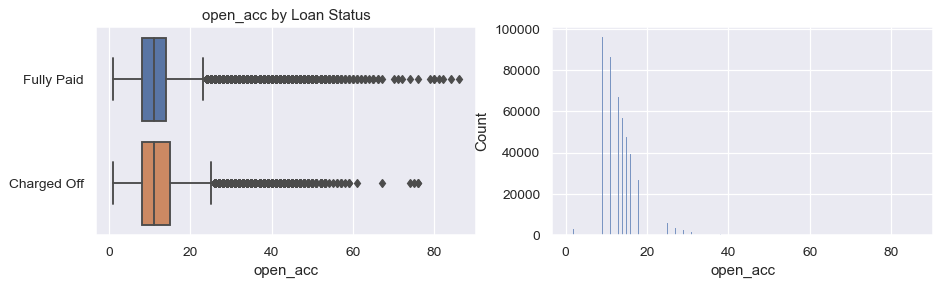

In [193]:
plot_var(col, col, continuous=True)

In [194]:
skew(loans[col])

1.3047116641207854

There is high right skewness and multiple outliers. I will log transform open_acc

In [195]:
loans['log_open_acc'] = loans[col].apply(lambda x: np.log10(x+1))

In [196]:
skew(loans['log_open_acc'])

-0.10371808584141051

In [197]:
loans.drop(['open_acc'], axis = 1, inplace = True)

<h4> 4.2.16. pub_rec

Number of derogatory public records

In [198]:
col = 'pub_rec'

In [199]:
loans[col].describe()

count   1066288.00
mean          0.23
std           0.62
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          86.00
Name: pub_rec, dtype: float64

In [200]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,213636.00,0.25,0.67,0.00,0.00,0.00,0.00,86.00
Fully Paid,852652.00,0.22,0.61,0.00,0.00,0.00,0.00,63.00


People with higher derogatory public records have more chance to Charge Off loans

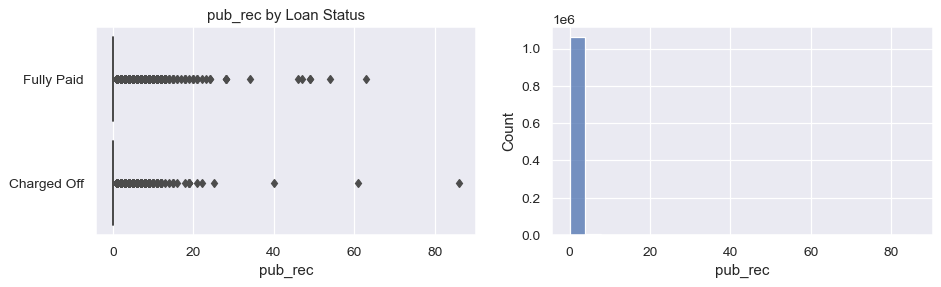

In [201]:
plot_var(col, col, continuous=True)

In [202]:
loans[col].value_counts()

pub_rec
0.00     873994
1.00     160765
2.00      20814
3.00       6309
4.00       2217
5.00       1073
6.00        515
7.00        235
8.00        126
9.00         69
10.00        44
11.00        35
12.00        25
13.00        15
15.00         8
19.00         5
18.00         5
21.00         4
14.00         4
28.00         3
20.00         3
16.00         3
49.00         2
22.00         2
24.00         2
34.00         1
61.00         1
25.00         1
54.00         1
86.00         1
63.00         1
40.00         1
46.00         1
47.00         1
23.00         1
17.00         1
Name: count, dtype: int64

In [203]:
(loans[col] >= 3).sum()

10715

As there are 8000 people with 3 or more loans. I decided to convert all values higher than 1 to 1. Thanks to this we have 2 categories:
- 0 - no public records
- 1 - 1 or more public record

In [204]:
loans[col].where(loans[col] <= 0, 1, inplace=True)

In [205]:
loans[col].value_counts()

pub_rec
0.00    873994
1.00    192294
Name: count, dtype: int64

In [206]:
loans[col].describe()

count   1066288.00
mean          0.18
std           0.38
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: pub_rec, dtype: float64

In [207]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,213636.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00
Fully Paid,852652.00,0.18,0.38,0.00,0.00,0.00,0.00,1.00


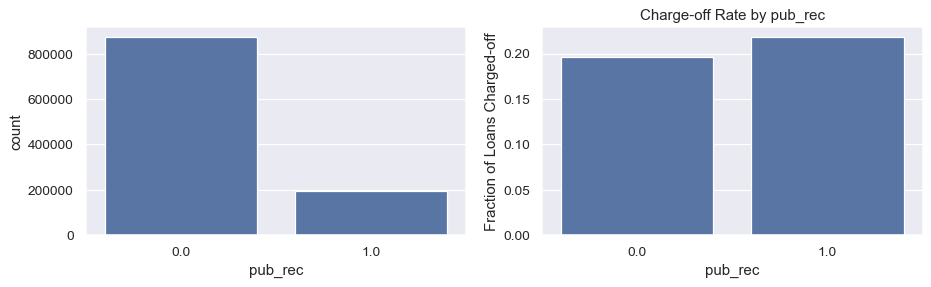

In [208]:
plot_var(col, col, continuous=False)

In [209]:
loans.groupby(col)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

pub_rec
0.00   0.20
1.00   0.22
Name: proportion, dtype: float64

There is slightly higher chance to Charge Off the loan if borrower had derogatory public record

<h4> 4.2.17. revol_bal

Total credit revolving balance

In [210]:
col = 'revol_bal'

In [211]:
loans[col].describe()

count   1066288.00
mean      15201.67
std       19167.94
min           0.00
25%        6025.00
50%       10917.00
75%       18699.00
max     2568995.00
Name: revol_bal, dtype: float64

In [212]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,213636.00,14416.58,16055.96,0.00,6018.00,10829.00,18140.25,867528.00
Fully Paid,852652.00,15398.38,19866.60,0.00,6027.00,10938.00,18851.00,2568995.00


Borrowers with lower credit revolving balance has higher chance to Charge Off the loan

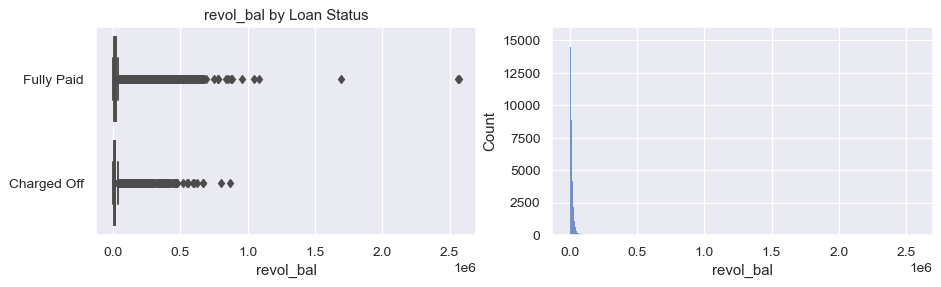

In [213]:
plot_var(col, col, continuous=True)

In [214]:
skew(loans[col])

13.861444363739883

There is high right skewness. I will log transform this feature

In [215]:
loans['log_revol_bal'] = loans[col].apply(lambda x: np.log10(x+1))

In [216]:
skew(loans['log_revol_bal'])

-2.4149185296814752

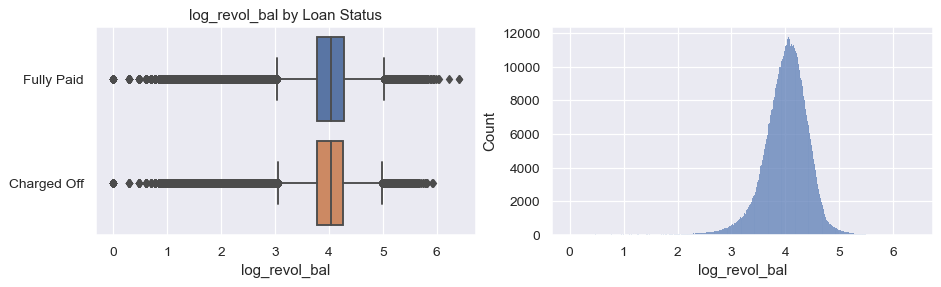

In [217]:
plot_var('log_revol_bal', 'log_revol_bal', continuous=True)

In [218]:
(loans['log_revol_bal']<= 2).sum()

5806

In [219]:
(loans['log_revol_bal']>= 6).sum()

5

There are too many outliers in this feature. I'll drop lower or equal 2 and higher or equal 6

In [220]:
loans = loans.drop(loans[(loans['log_revol_bal'] <= 2)].index).reset_index(drop=True)
loans = loans.drop(loans[(loans['log_revol_bal'] >= 6)].index).reset_index(drop=True)

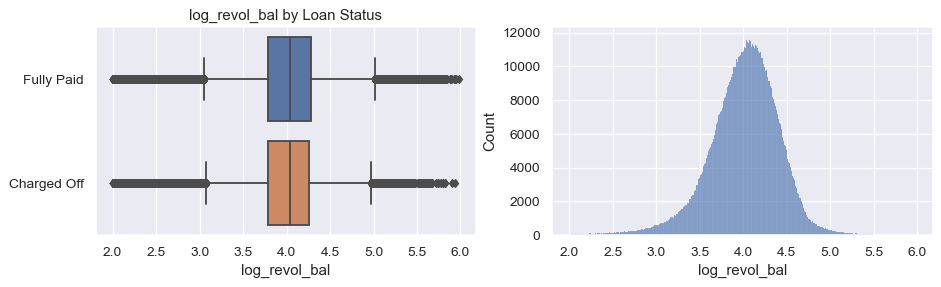

In [221]:
plot_var('log_revol_bal', 'log_revol_bal', continuous=True)

In [222]:
loans['log_revol_bal'].describe()

count   1060477.00
mean          4.01
std           0.40
min           2.00
25%           3.79
50%           4.04
75%           4.27
max           5.98
Name: log_revol_bal, dtype: float64

In [223]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,212463.00,14496.05,16064.46,100.00,6092.00,10890.00,18196.00,867528.00
Fully Paid,848014.00,15471.93,19346.23,100.00,6099.25,10999.00,18915.00,959754.00


In [224]:
skew(loans['log_revol_bal'])

-0.5854878485155497

In [225]:
loans.drop(['revol_bal'], axis = 1, inplace = True)

<h4> 4.2.18. revol_util

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [226]:
col = 'revol_util'

In [227]:
loans[col].describe()

count   1060477.00
mean         53.61
std          23.25
min           0.00
25%          36.10
50%          53.60
75%          71.40
max         892.30
Name: revol_util, dtype: float64

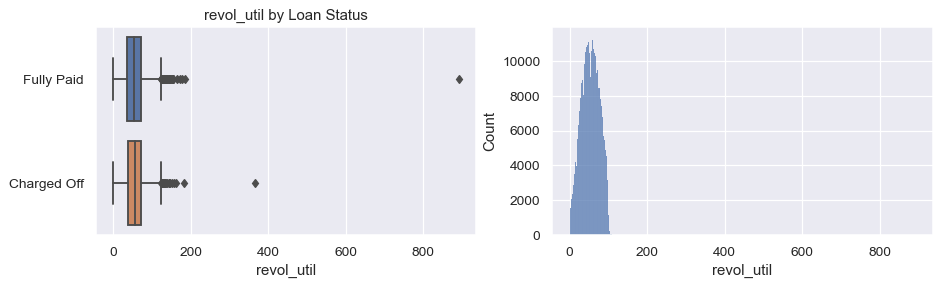

In [228]:
plot_var(col, col, continuous=True)

There are some outliers causing that boxplot is unreadable. I will drop all values higher than 200.

In [229]:
loans = loans.drop(loans[loans[col] >200].index).reset_index(drop = True)

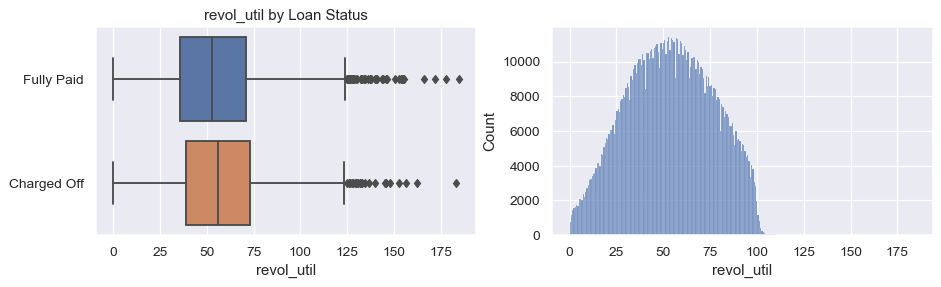

In [230]:
plot_var(col, col, continuous=True)

In [231]:
(loans[col] > 100).sum()

3993

Histogram shows, that there is small amount values higher than 100. I will drop all values higher or equal 100.

In [232]:
loans = loans.drop(loans[loans[col] >= 100].index).reset_index(drop = True)

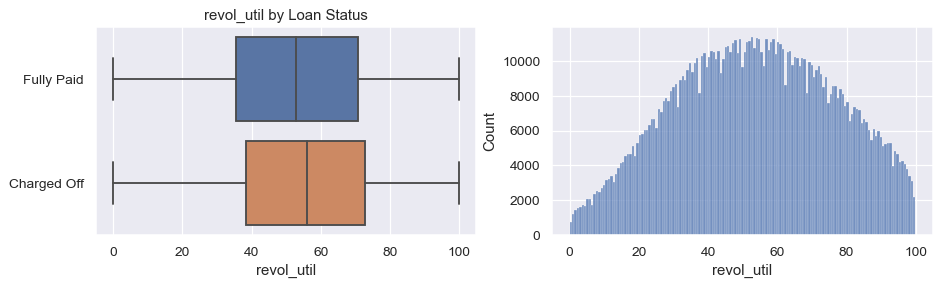

In [233]:
plot_var(col, col, continuous=True)

In [234]:
skew(loans[col])

-0.052729005602809645

In [235]:
loans[col].describe()

count   1056080.00
mean         53.41
std          23.06
min           0.00
25%          36.00
50%          53.50
75%          71.10
max          99.90
Name: revol_util, dtype: float64

In [236]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,211347.00,55.35,22.71,0.00,38.50,55.90,72.90,99.90
Fully Paid,844733.00,52.92,23.12,0.00,35.40,52.90,70.70,99.90


Charge Off status has higher revolving line utilization rate mean

<h4> 4.2.19. total_acc

The total number of credit lines currently in the borrower's credit file

In [237]:
col = 'total_acc'

In [238]:
loans[col].describe()

count   1056080.00
mean         24.79
std          11.90
min           2.00
25%          16.00
50%          23.00
75%          31.00
max         176.00
Name: total_acc, dtype: float64

In [239]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,211347.00,24.62,11.99,2.00,16.00,23.00,31.00,176.00
Fully Paid,844733.00,24.83,11.88,2.00,16.00,23.00,32.00,156.00


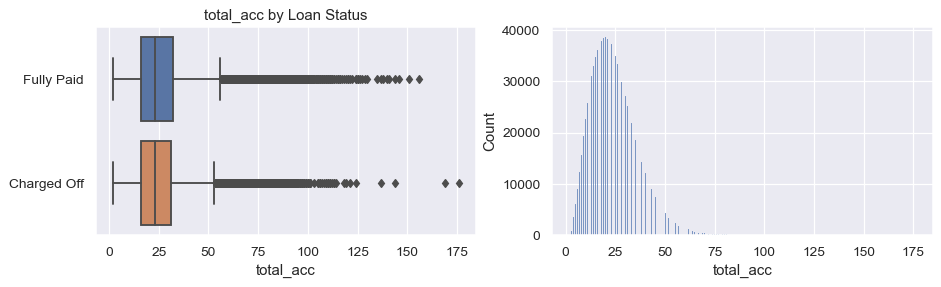

In [240]:
plot_var(col, col, continuous=True)

In [241]:
(loans[col] > 50).sum()

34381

In [242]:
(loans[col] >= 50).sum()

38686

In [243]:
skew(loans[col])

0.9709357555051412

There is a lot of outliers and high feature is highy right-skewed. I will drop all values higher or equal than 50

In [244]:
loans = loans.drop(loans[loans[col] >= 50].index).reset_index(drop = True)

In [245]:
skew(loans[col])

0.3815545292238244

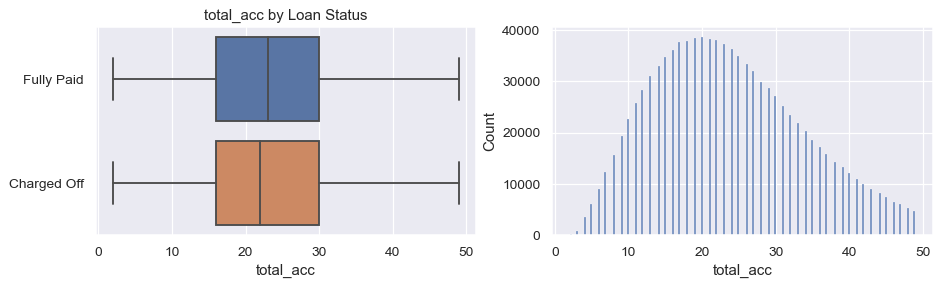

In [246]:
plot_var(col, col, continuous=True)

In [247]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,203497.00,23.33,10.07,2.00,16.00,22.00,30.00,49.00
Fully Paid,813897.00,23.58,10.06,2.00,16.00,23.00,30.00,49.00


Total number of credit lines in borrowers credit file is higher for loans with Fully Paid status.

<h4> 4.2.20. initial_list_status

The initial listing status of the loan. Possible values are – W, F.

I could not find what does it means.

In [248]:
col = 'initial_list_status'

In [249]:
loans[col].describe()

count     1017394
unique          2
top             w
freq       603762
Name: initial_list_status, dtype: object

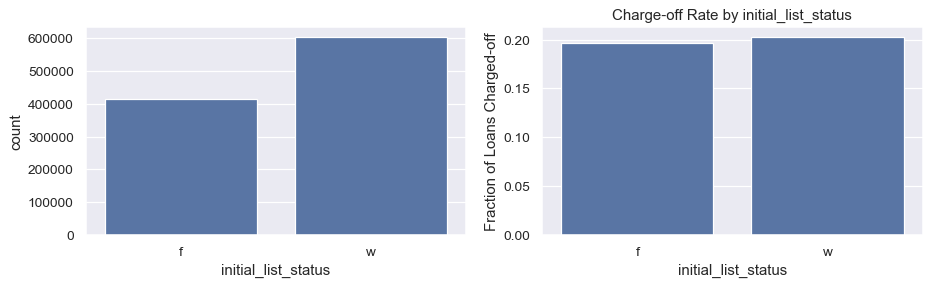

In [250]:
plot_var(col, col, continuous=0)

In [251]:
loans.groupby('loan_status')[col].describe()

,count,unique,top,freq
loan_status,,,,
Charged Off,203497,2,w,122360
Fully Paid,813897,2,w,481402


<h4> 4.2.21. application_type

In [252]:
col = 'application_type'

In [253]:
loans[col].describe()

count        1017394
unique             2
top       Individual
freq         1004655
Name: application_type, dtype: object

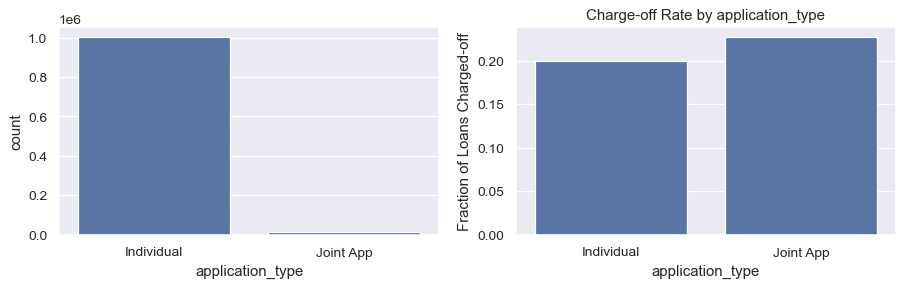

In [254]:
plot_var(col, col, continuous=0)

In [255]:
loans[col].value_counts(normalize = 1)

application_type
Individual   0.99
Joint App    0.01
Name: proportion, dtype: float64

In [256]:
loans.groupby(col)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual   0.20
Joint App    0.23
Name: proportion, dtype: float64

Joint App loans are more likely to be charged-off.

<h4> 4.2.22. mort_acc

Number of mortgage accounts

In [257]:
col = 'mort_acc'

In [258]:
loans[col].describe()

count   1017394.00
mean          1.52
std           1.89
min           0.00
25%           0.00
50%           1.00
75%           2.00
max          30.00
Name: mort_acc, dtype: float64

In [259]:
loans[col].value_counts(dropna=False)

mort_acc
0.00     440813
1.00     181031
2.00     144297
3.00     101680
4.00      66842
5.00      39452
6.00      21832
7.00      10817
8.00       5196
9.00       2598
10.00      1300
11.00       679
12.00       342
13.00       180
14.00       135
15.00        64
16.00        48
17.00        27
18.00        18
19.00        10
20.00         7
22.00         5
21.00         4
23.00         4
25.00         3
27.00         3
24.00         3
26.00         2
30.00         1
28.00         1
Name: count, dtype: int64

In [260]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,203497.00,1.25,1.72,0.00,0.00,1.00,2.00,27.00
Fully Paid,813897.00,1.58,1.92,0.00,0.00,1.00,3.00,30.00


People with higher amount of loans in history have higher probability to Fully Paid loans.

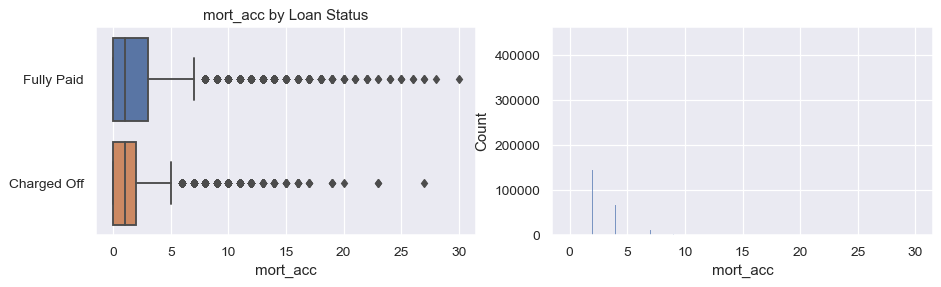

In [261]:
plot_var(col, col, continuous=True)

In [262]:
skew(loans[col])

1.594177686328007

In [263]:
(loans[col]> 3).sum()

149573

There is huge amount of outliers higher than 3. I decided to create categories:
- 0 - no mortgages
- 1 - 1 mortgage
- 2 - 2 mortgages
- 3 - 3 mortgages
- 4 - 4 or more mortgages

In [264]:
loans[col].where(loans[col] <= 3, 4, inplace=True)

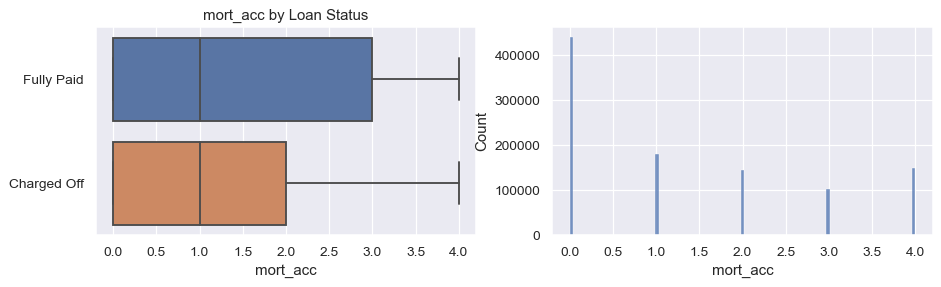

In [265]:
plot_var(col, col, continuous=True)

In [266]:
skew(loans[col])

0.6709631798674824

In [267]:
loans.groupby('loan_status')[col].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,203497.00,1.13,1.40,0.00,0.00,1.00,2.00,4.00
Fully Paid,813897.00,1.40,1.49,0.00,0.00,1.00,3.00,4.00


Borrowers with less mortgage accounts are more tend to Charge Off

<h4> 4.2.23. pub_rec_bankruptcies

Number of public record bankruptcies.

In [268]:
col = 'pub_rec_bankruptcies'

In [269]:
loans[col].describe()

count   1017394.00
mean          0.14
std           0.39
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          12.00
Name: pub_rec_bankruptcies, dtype: float64

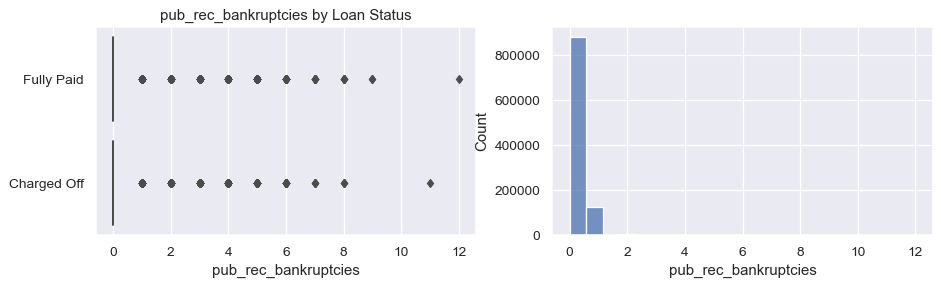

In [270]:
plot_var(col, col, continuous=1)

In [271]:
loans[col].value_counts(normalize = 1)

pub_rec_bankruptcies
0.00    0.87
1.00    0.12
2.00    0.01
3.00    0.00
4.00    0.00
5.00    0.00
6.00    0.00
7.00    0.00
8.00    0.00
9.00    0.00
11.00   0.00
12.00   0.00
Name: proportion, dtype: float64

I'll replace 2.0 with 1 and convert it into:
- 0: no public bankrupties;
- 1: there were public bankrupties.

In [272]:
loans[col].where(loans[col] <= 1, 1, inplace=True)

In [273]:
loans[col].value_counts(normalize = 1)

pub_rec_bankruptcies
0.00   0.87
1.00   0.13
Name: proportion, dtype: float64

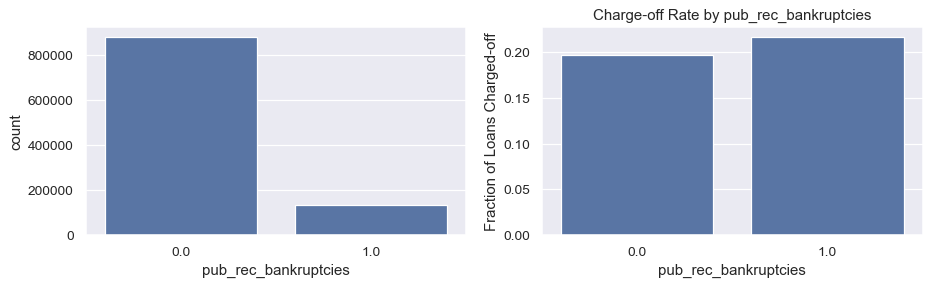

In [274]:
plot_var(col, col, continuous=0)

In [275]:
loans.groupby(col)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

pub_rec_bankruptcies
0.00   0.20
1.00   0.22
Name: proportion, dtype: float64

Borrowers without any public record bankruptcy are slightly less likely to Charge Off their loans

In [276]:
print(list(loans.columns))

['loan_amnt', 'term', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'pub_rec', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'log_int_rate', 'log_Installment', 'log_annual_inc', 'region', 'FICO', 'log_open_acc', 'log_revol_bal']


In [277]:
loans.shape

(1017394, 26)

In [278]:
loans.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1017394.00,13117.77,7118.16,1000.00,7500.00,12000.00,18000.00,34975.00
installment,1017394.00,396.94,202.49,4.93,245.96,360.33,528.19,949.98
annual_inc,1017394.00,72003.19,61415.21,2000.00,45000.00,62000.00,85000.00,9500000.00
dti,1017394.00,18.24,8.28,0.00,12.00,17.74,24.13,39.99
earliest_cr_line,1017394.00,1999.42,7.23,1934.00,1996.00,2001.00,2004.00,2015.00
pub_rec,1017394.00,0.18,0.38,0.00,0.00,0.00,0.00,1.00
revol_util,1017394.00,53.69,23.05,0.00,36.40,53.80,71.50,99.90
total_acc,1017394.00,23.53,10.06,2.00,16.00,23.00,30.00,49.00
mort_acc,1017394.00,1.35,1.48,0.00,0.00,1.00,2.00,4.00
pub_rec_bankruptcies,1017394.00,0.13,0.34,0.00,0.00,0.00,0.00,1.00


<h3> 5. Feature Engineering

I'll prepare some additional features, they might be usefull to predict loan status.

<h4> 5.1. percRepay

<b>The percentage of annual income borrower have to repay every year.

In [279]:
loans['percRepay'] = (loans['installment']*12)/loans['annual_inc']

In [280]:
loans.drop(['annual_inc'], axis = 1, inplace = True)

In [281]:
loans.drop(['installment'], axis = 1, inplace = True)

In [282]:
loans['percRepay'].describe()

count   1017394.00
mean          0.08
std           0.04
min           0.00
25%           0.05
50%           0.07
75%           0.10
max           1.88
Name: percRepay, dtype: float64

In [283]:
loans.groupby('loan_status')['percRepay'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,203497.00,0.09,0.04,0.00,0.05,0.08,0.11,1.06
Fully Paid,813897.00,0.07,0.04,0.00,0.04,0.07,0.10,1.88


Charge Off has higher mean percent

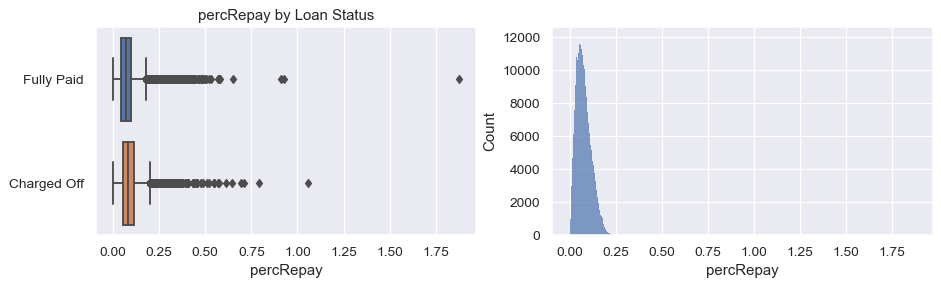

In [284]:
plot_var('percRepay','percRepay',continuous = True)

In [285]:
skew(loans['percRepay'])

0.9325479012090515

In [286]:
(loans['percRepay'] > 0.2).sum()

4594

There is high skewness. I will drop rows hogher than 0.3

In [287]:
loans = loans.drop(loans[(loans['percRepay'] > 0.2)].index).reset_index(drop=True)

In [288]:
skew(loans['percRepay'])

0.5885528749801608

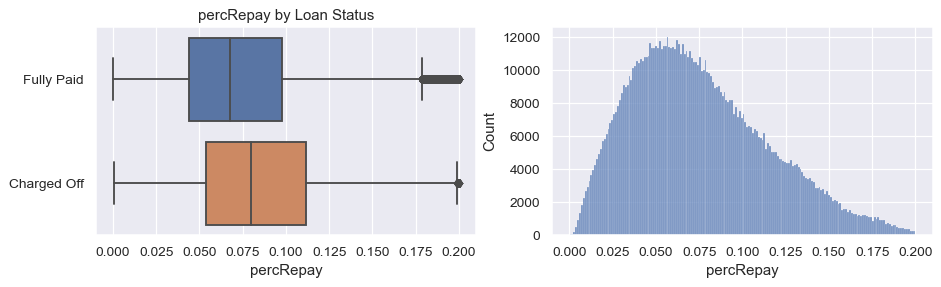

In [289]:
plot_var('percRepay','percRepay',continuous = True)

<h4> 5.2. Convert target into 1/0 indicator

I'll convert loan status into integer values: 1 - Fully Paid and 0: Charged Off.

In [290]:
loans['loan_status'] = loans['loan_status'].map({'Fully Paid' : 1, 'Charged Off' : 0}) 

In [291]:
loans['loan_status'].sample(5)

739634    1
663387    1
842212    1
755865    1
89581     1
Name: loan_status, dtype: int64

In [292]:
loans.columns.to_list()

['loan_amnt',
 'term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'dti',
 'earliest_cr_line',
 'pub_rec',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'application_type',
 'mort_acc',
 'pub_rec_bankruptcies',
 'log_int_rate',
 'log_Installment',
 'log_annual_inc',
 'region',
 'FICO',
 'log_open_acc',
 'log_revol_bal',
 'percRepay']

<h4> 5.3. Convert features into numbers

Strip 'months' from 'term' feature

In [293]:
loans['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [294]:
loans['term'] = loans['term'].str.strip(' months').astype(int)

In [295]:
loans['term'].unique()

array([36, 60])

Strip 'years' from 'emp_length'

In [296]:
loans['emp_length'].unique()

array(['10 years', '3 years', '4 years', '6 years', '7 years', '8 years',
       '2 years', '5 years', '0 year', '1 year', '9 years'], dtype=object)

In [297]:
loans['emp_length'] = loans['emp_length'].str.strip(' years').astype(int)

In [298]:
loans['emp_length'].unique()

array([10,  3,  4,  6,  7,  8,  2,  5,  0,  1,  9])

Convert home ownership types into numbers
- MORTGAGE = 0
- RENT = 1
- OWN = 2
- OTHER = 3

In [299]:
loans['home_ownership'].unique()

array(['MORTGAGE', 'RENT', 'OWN', 'OTHER'], dtype=object)

In [300]:
loans['home_ownership'] = loans['home_ownership'].map({'MORTGAGE' : 0, 'RENT' : 1, 'OWN' : 2, 'OTHER' : 3}) 

In [301]:
loans['home_ownership'].unique()

array([0, 1, 2, 3], dtype=int64)

Convert verification_statuses into numbers
- Not Verified = 0
- Source Verified = 1
- Verified = 2

In [302]:
loans['verification_status'].unique()

array(['Not Verified', 'Source Verified', 'Verified'], dtype=object)

In [303]:
loans['verification_status'] = loans['verification_status'].map({'Not Verified' : 0, 'Source Verified' : 1, 'Verified' : 2})

In [304]:
loans['verification_status'].unique()

array([0, 1, 2], dtype=int64)

Convert regions into numbers
- SouthEast = 0
- West = 1
- NorthEast = 2
- MidWest = 3
- SouthWest = 4

In [305]:
loans['region'] = loans['region'].map({'SouthEast' : 0, 'West' : 1, 'NorthEast' : 2, 'MidWest' : 3, 'SouthWest' : 4}) 

In [306]:
loans['region'].unique()

array([2, 3, 0, 1, 4], dtype=int64)

Convert initial_list_status into 1/0 indicators

In [307]:
loans['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [308]:
loans['initial_list_status'] = loans['initial_list_status'].map({'w' : 1, 'f' : 0}) 

In [309]:
loans['initial_list_status'].unique()

array([1, 0], dtype=int64)

Convert application_type into 1/0 indicators

In [310]:
loans['application_type'].unique()

array(['Individual', 'Joint App'], dtype=object)

In [311]:
loans['application_type'] = loans['application_type'].map({'Individual' : 1, 'Joint App' : 0}) 

In [312]:
loans['application_type'].unique()

array([1, 0], dtype=int64)

Convert purpose into numbers:

- debt_consolidation = 0
- small_business = 1
- house = 2
- major_purchase = 3
- other = 4
- car = 5
- medical = 6
- vacation = 7
- moving = 8
- wedding = 9

In [313]:
loans['purpose'].unique()

array(['debt_consolidation', 'small_business', 'house', 'major_purchase',
       'other', 'car', 'medical', 'vacation', 'moving', 'wedding'],
      dtype=object)

In [314]:
loans['purpose'] = loans['purpose'].map({'debt_consolidation' : 0, 'small_business' : 1, 'house' : 2, 'major_purchase' : 3,
       'other' : 4, 'car' : 5, 'medical' : 6, 'vacation' : 7, 'moving' :8, 'wedding' : 9}) 

In [315]:
loans['grade'].unique()

array(['C', 'B', 'F', 'A', 'E', 'D', 'G'], dtype=object)

In [316]:
loans['grade'] = loans['grade'].map({'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3,
       'E' : 4, 'F' : 5, 'G' : 6}) 

In [317]:
loans['grade'].unique()

array([2, 1, 5, 0, 4, 3, 6], dtype=int64)

<h4> 5.4. Choosing features statistically significant

In [318]:
print(list(loans.columns))

['loan_amnt', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'pub_rec', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'log_int_rate', 'log_Installment', 'log_annual_inc', 'region', 'FICO', 'log_open_acc', 'log_revol_bal', 'percRepay']


In [319]:
loans.shape

(1012800, 25)

In [320]:
from scipy import stats

importance = []
 
for x in loans[1:]:
    pvalue = stats.ttest_ind(loans.loc[loans.loan_status==1][x], loans.loc[loans.loan_status==0][x])[1]
    if pvalue<0.05:
        importance.append(x)
        print(f'The variable {x} is statistically significant with a pvalue = {pvalue:.2}')
        
print('\n Number of statistically significant features with traget: ', len(importance))

The variable loan_amnt is statistically significant with a pvalue = 0.0
The variable term is statistically significant with a pvalue = 0.0
The variable grade is statistically significant with a pvalue = 0.0
The variable emp_length is statistically significant with a pvalue = 1.1e-43
The variable home_ownership is statistically significant with a pvalue = 0.0
The variable verification_status is statistically significant with a pvalue = 0.0
The variable loan_status is statistically significant with a pvalue = 0.0
The variable dti is statistically significant with a pvalue = 0.0
The variable earliest_cr_line is statistically significant with a pvalue = 0.0
The variable pub_rec is statistically significant with a pvalue = 7.5e-99
The variable revol_util is statistically significant with a pvalue = 0.0
The variable total_acc is statistically significant with a pvalue = 8.5e-21
The variable initial_list_status is statistically significant with a pvalue = 2.2e-16
The variable application_type

In [321]:
loans = loans[importance]

<h4> 5.5. Training Data preparation

In [322]:
loans.shape

(1012800, 23)

Getting dummies

In [323]:
loanData = pd.get_dummies(loans)

In [324]:
loanData.sample(5)

,loan_amnt,term,grade,emp_length,home_ownership,verification_status,loan_status,dti,earliest_cr_line,pub_rec,...,application_type,mort_acc,pub_rec_bankruptcies,log_int_rate,log_Installment,log_annual_inc,FICO,log_open_acc,log_revol_bal,percRepay
868747,14100.00,36,0,1,2,1,1,26.79,2000,0.00,...,1,0.00,0.00,1.04,2.65,4.60,717.00,1.08,4.11,0.13
743080,12000.00,60,2,10,1,0,1,6.94,1995,1.00,...,1,1.00,1.00,1.23,2.46,4.78,697.00,0.85,3.85,0.06
545197,14400.00,36,1,1,1,1,0,29.08,2000,0.00,...,1,0.00,0.00,1.08,2.67,4.68,732.00,1.18,4.13,0.12
22724,7000.00,36,2,10,1,2,1,12.27,2003,0.00,...,1,0.00,0.00,1.20,2.38,4.90,662.00,1.18,4.07,0.04
370037,11200.00,36,0,3,1,1,1,10.97,2004,0.00,...,1,0.00,0.00,0.97,2.54,4.86,702.00,1.30,4.07,0.06


In [325]:
loanData.columns.to_list()

['loan_amnt',
 'term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'loan_status',
 'dti',
 'earliest_cr_line',
 'pub_rec',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'application_type',
 'mort_acc',
 'pub_rec_bankruptcies',
 'log_int_rate',
 'log_Installment',
 'log_annual_inc',
 'FICO',
 'log_open_acc',
 'log_revol_bal',
 'percRepay']

In [326]:
loanData.shape

(1012800, 23)

In [327]:
missing_data = loanData.isnull().mean().sort_values(ascending=False)
missing_data.head()

loan_amnt             0.00
initial_list_status   0.00
log_revol_bal         0.00
log_open_acc          0.00
FICO                  0.00
dtype: float64

There are 70 features without NaN values

<h2> 6. Prepare Data for Model Training and Testing

Divide our Data Set for 2 variables X for all features without target and y for target.

In [328]:
X = loanData.drop(['loan_status'], axis=1)
y = loanData['loan_status']

<h4> 6.1. Dealing with unbalanced class samples

As my dataset is unbalanced, I decided to undersample as my PC is not strong enough to oversample

In [329]:
from imblearn.over_sampling import RandomOverSampler

Divide our Data Set for 2 variables X for all features without target and y for target.

In [330]:
X = loanData.drop(['loan_status'], axis=1)
y = loanData['loan_status']

In [331]:
oversampler = RandomOverSampler()

In [332]:
X_res, y_res = oversampler.fit_resample(X, y)

In [333]:
X_res.shape

(1621492, 22)

<h4>6.2. Standarization of the features

Standarization of "LoanData" Data Frame

In [334]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib as mpl
from cycler import cycler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [335]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.3, random_state=2137)

<h2> 7. Defining functions for model training

Prepare function for prediction f1-score and accuracy of the model

In [337]:
def evaluate(prediction,y_test): 
    result = classification_report(y_test,prediction,output_dict=True)
    f1 = result['1']['f1-score']
    accuracy = result['accuracy']
    performance_data= {'f1-score':round(f1, 2),
                      'accuracy':round(accuracy, 2)}
    return performance_data

<h2> 8. Model training

<h4> 8.1. Logistic Regression

In [338]:
current_model = 'Logistic Regression'
learning_model = "Learning Curve for " + current_model 
model = LogisticRegression(max_iter = 10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [339]:
lr_pred = model.predict(X_test)

In [340]:
lr_prediction = model.predict_proba(X_test)[:, 1]

<h5> 8.1.1. Visualization ROC Curve

ROC AUC : 0.7018


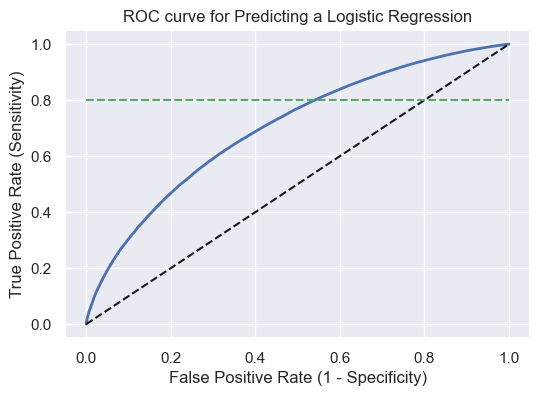

In [341]:
fpr, tpr, thresholds = roc_curve(y_test, lr_prediction)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.hlines(y=0.80, xmax=1, xmin=0, colors="g", linestyles="--")
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
lr_auc = roc_auc_score(y_test, lr_prediction)
print('ROC AUC : {:.4f}'.format(lr_auc))
plt.show()

In [342]:
confusion_matrix(y_test, lr_pred)

array([[154369,  89038],
       [ 83357, 159684]], dtype=int64)

In [343]:
print(classification_report(y_test,lr_pred))

dtree_pr= evaluate(lr_pred,y_test)
dtree_pr

              precision    recall  f1-score   support

           0       0.65      0.63      0.64    243407
           1       0.64      0.66      0.65    243041

    accuracy                           0.65    486448
   macro avg       0.65      0.65      0.65    486448
weighted avg       0.65      0.65      0.65    486448



{'f1-score': 0.65, 'accuracy': 0.65}

In [344]:
evaluate(y_test, lr_pred)

{'f1-score': 0.65, 'accuracy': 0.65}

<h5> 8.1.2. Model Summary

In [345]:
model_summary = evaluate(y_test, lr_pred)
model_summary['model'] = current_model
model_summary['auroc'] = lr_auc
pd.DataFrame([model_summary])

,f1-score,accuracy,model,auroc
0,0.65,0.65,Logistic Regression,0.70


AUROC score is equal 0.70

<h4> 8.2. Decision Tree

In [346]:
current_model = 'Decision Tree'
learning_model = "Learning Curve for " + current_model 
model = DecisionTreeClassifier(max_depth=100)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=100)

In [347]:
dt_prediction = model.predict(X_test)

<h4>Visualization of Decision Tree

As visualization is unreadable I decided to not run code below

In [348]:
#tree.plot_tree(model)

<h5> 8.2.1. Visualization of ROC Curve

ROC AUC : 0.8633


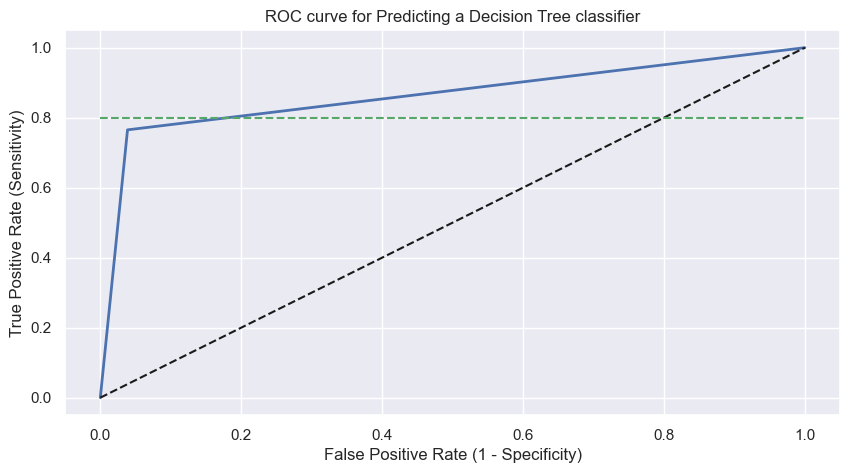

In [349]:
fpr, tpr, thresholds = roc_curve(y_test, dt_prediction)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.hlines(y=0.80, xmax=1, xmin=0, colors="g", linestyles="--")
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Decision Tree classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
dt_auc = roc_auc_score(y_test, dt_prediction)
print('ROC AUC : {:.4f}'.format(dt_auc))
plt.show()

In [350]:
confusion_matrix(y_test, dt_prediction)

array([[234006,   9401],
       [ 57067, 185974]], dtype=int64)

In [351]:
print(classification_report(y_test,dt_prediction))

dtree_pr= evaluate(dt_prediction,y_test)
dtree_pr

              precision    recall  f1-score   support

           0       0.80      0.96      0.88    243407
           1       0.95      0.77      0.85    243041

    accuracy                           0.86    486448
   macro avg       0.88      0.86      0.86    486448
weighted avg       0.88      0.86      0.86    486448



{'f1-score': 0.85, 'accuracy': 0.86}

<h5> 8.2.2. Model Summary

In [352]:
model_summary = evaluate(y_test, dt_prediction)
model_summary['model'] = current_model
model_summary['auroc'] = dt_auc
pd.DataFrame([model_summary])

,f1-score,accuracy,model,auroc
0,0.85,0.86,Decision Tree,0.86


AUROC score is equal 0.86

<h4> 8.3. Random Forest

In [353]:
current_model = 'Random Forest Classifier'
learning_model = "Learning Curve for " + current_model 
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [354]:
rf_prediction = model.predict(X_test)

<h5> 8.3.1. Visualization of ROC Curve

ROC AUC : 0.9306


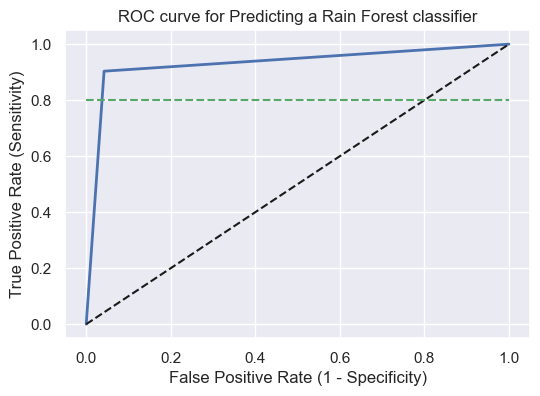

In [355]:
fpr, tpr, thresholds = roc_curve(y_test, rf_prediction)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.hlines(y=0.80, xmax=1, xmin=0, colors="g", linestyles="--")
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Rain Forest classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
rf_auc = roc_auc_score(y_test, rf_prediction)
print('ROC AUC : {:.4f}'.format(rf_auc))
plt.show()

In [356]:
confusion_matrix(y_test, rf_prediction)

array([[233121,  10286],
       [ 23443, 219598]], dtype=int64)

In [357]:
print(classification_report(y_test,rf_prediction))
rf_pr = evaluate(rf_prediction,y_test)
print(rf_pr)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93    243407
           1       0.96      0.90      0.93    243041

    accuracy                           0.93    486448
   macro avg       0.93      0.93      0.93    486448
weighted avg       0.93      0.93      0.93    486448

{'f1-score': 0.93, 'accuracy': 0.93}


<h5> 8.3.2. Model Summary

In [358]:
model_summary = evaluate(y_test, rf_prediction)
model_summary['model'] = current_model
model_summary['auroc'] = rf_auc
pd.DataFrame([model_summary])

,f1-score,accuracy,model,auroc
0,0.93,0.93,Random Forest Classifier,0.93


Random Forest Classifier has high f1-scora, accuracy and AUROC score 0.93

<h4> 8.4. K Nearest Neighbors Classifier (KNN)

In [359]:
current_model = 'K Nearest Neighbors Classifier'
learning_model = "Learning Curve for " + current_model 
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [360]:
knn_prediction = model.predict(X_test)

<h5> 8.4.1. Visualization of ROC Curve

ROC AUC : 0.6776


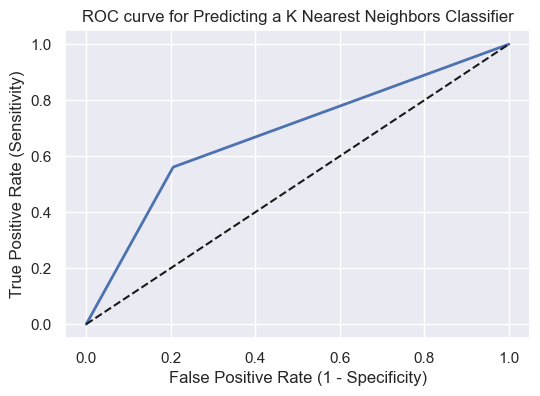

In [361]:
fpr, tpr, thresholds = roc_curve(y_test, knn_prediction)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a K Nearest Neighbors Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
knn_auc = roc_auc_score(y_test, knn_prediction)
print('ROC AUC : {:.4f}'.format(knn_auc))
plt.show()

In [362]:
confusion_matrix(y_test, knn_prediction)

array([[193310,  50097],
       [106668, 136373]], dtype=int64)

In [363]:
print(classification_report(knn_prediction,y_test))
knn1_pr = evaluate(knn_prediction,y_test)
knn1_pr

              precision    recall  f1-score   support

           0       0.79      0.64      0.71    299978
           1       0.56      0.73      0.64    186470

    accuracy                           0.68    486448
   macro avg       0.68      0.69      0.67    486448
weighted avg       0.70      0.68      0.68    486448



{'f1-score': 0.64, 'accuracy': 0.68}

<h5> 8.4.2. Model Summary

In [364]:
model_summary = evaluate(y_test, knn_prediction)
model_summary['model'] = current_model
model_summary['auroc'] = knn_auc
pd.DataFrame([model_summary])

,f1-score,accuracy,model,auroc
0,0.64,0.68,K Nearest Neighbors Classifier,0.68


K Nearest Neighbors Classifier has auroc 0.68

<h2> 9. Model Training Summary

In [365]:
prediction_data={'Model':['Logistic Regression',
                          'Decision Tree',
                          'Random Forest',
                          'KNN'
                         ],
                    'ROC AUC':[lr_auc,
                              dt_auc, 
                              rf_auc,
                              knn_auc]
                    }
 
# Create DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Model,ROC AUC
0,Logistic Regression,0.70
1,Decision Tree,0.86
2,Random Forest,0.93
3,KNN,0.68


The highest ROC AUC score has Random Forest Classifier

<h2> 10. Conclusions

I applied 4 machine learning methods to predict the probability that a requested loan on LendingClub will charge off. Comparison of cross-validated AUROC score shows that for data provided to the models, the best one is Random Forest Classifier and Decision Tree. 

This models, while far from perfect, can provide a somewhat informed prediction of the likelihood that a loan will charge off, using only data available to potential investors before the loan is fully funded.

